In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960 
DATASET_MAPPING = 'halite:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%252F18011%252F1099604%252Fbundle%252Farchive.zip%3FGoogleAccessId%3Dgcp-kaggle-com%40kaggle-161607.iam.gserviceaccount.com%26Expires%3D1597367433%26Signature%3DQMHhiEAyfDQoN%252Fiv2yn7KHipnCbsbY3m93sy%252Bt8L2Wqdekib%252BaFNEHGcKpYLgxhTPpfER%252BCX5Psj%252FVwx%252F6aHIkQPGRhxSRibL1ooz1dUQd5RpK4pM0jIZ5K6IefwvzhcU8oD0JHz1tPPXbLY62%252B5PM6OisO42bn6Qua%252F5H1aUotmNz3HsXe%252FvtDUygMdFd4XEApsBkgwkI7%252FFwHRKbVQ759UWFz6A72o3JPKJ8PMzWXjN9hBAGOOneP%252FwLai8%252B0iBnt1I0OX4S5em53pB58dnFSoJzI%252FgKV11TI4NDoZW9AqGq0g8AbHTS%252BClXiW%252B1PnHVJV%252FJxyS4moSNPLFNAm5A%253D%253D,halitegame:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F756067%252F1404002%252Fbundle%252Farchive.zip%3FGoogleAccessId%3Dgcp-kaggle-com%40kaggle-161607.iam.gserviceaccount.com%26Expires%3D1597367433%26Signature%3DN8p%252FeLDeKetTI7Uj7llfPbkNSjTVPPw6558xtO4PqQCXVGaCrb%252BPSopaXuMAsLjYQ%252F0ORrqvsz1uRZBDPWpQcRk2YbfVwwHZV5CbOaMEE2mrgrfBVffN3%252FniWOutbLMg1lxTXi3GCkkWI70UI%252BlqY7K%252BvS%252BLE93UiCJq5jcIc6O3jZuUxXvcDBTuMRLCUvfXTfybdEpUhYj6hN7HRNWY8SCcaBq7cHaeH1x8qOlWvMGB6wnEXipM6Gjub7u3uXf7ogsNQMjPWJr6I3ZfuweCt6hY09Ee8d5BZCet44%252B5wl5ZpGYJtwK8ygADEzUdWV1LmbD47vEHBsOGo04enVYAUw%253D%253D'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

!mkdir -p -- $KAGGLE_INPUT_PATH
!chmod 777 $KAGGLE_INPUT_PATH
!ln -sfn $KAGGLE_INPUT_PATH ../
!mkdir -p -- $KAGGLE_INPUT_SYMLINK
!ln -sfn $KAGGLE_INPUT_PATH $KAGGLE_INPUT_SYMLINK

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')


In [1]:
import json
import numpy as np # linear algebra
from random import choices, randint, uniform
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from collections import OrderedDict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from kaggle_environments.envs.halite.helpers import *
from kaggle_environments import evaluate, make

# Swarm agent code

In [2]:
#FUNCTIONS###################################################
def get_map_and_average_halite(obs):
    """
        get average amount of halite per halite source
        and map as two dimensional array of objects and set amounts of halite in each cell
    """
    game_map = []
    halite_sources_amount = 0
    halite_total_amount = 0
    for x in range(conf.size):
        game_map.append([])
        for y in range(conf.size):
            game_map[x].append({
                # value will be ID of owner
                "shipyard": None,
                # value will be ID of owner
                "ship": None,
                # value will be amount of halite
                "ship_cargo": None,
                # amount of halite
                "halite": obs.halite[conf.size * y + x]
            })
            if game_map[x][y]["halite"] > 0:
                halite_total_amount += game_map[x][y]["halite"]
                halite_sources_amount += 1
    average_halite = halite_total_amount / halite_sources_amount
    return game_map, average_halite

def get_swarm_units_coords_and_update_map(s_env):
    """ get lists of coords of Swarm's units and update locations of ships and shipyards on the map """
    # arrays of (x, y) coords
    swarm_shipyards_coords = []
    swarm_ships_coords = []
    # place on the map locations of units of every player
    for player in range(len(s_env["obs"].players)):
        # place on the map locations of every shipyard of the player
        shipyards = list(s_env["obs"].players[player][1].values())
        for shipyard in shipyards:
            x = shipyard % conf.size
            y = shipyard // conf.size
            # place shipyard on the map
            s_env["map"][x][y]["shipyard"] = player
            if player == s_env["obs"].player:
                swarm_shipyards_coords.append((x, y))
        # place on the map locations of every ship of the player
        ships = list(s_env["obs"].players[player][2].values())
        for ship in ships:
            x = ship[0] % conf.size
            y = ship[0] // conf.size
            # place ship on the map
            s_env["map"][x][y]["ship"] = player
            s_env["map"][x][y]["ship_cargo"] = ship[1]
            if player == s_env["obs"].player:
                swarm_ships_coords.append((x, y))
    return swarm_shipyards_coords, swarm_ships_coords

def get_c(c):
    """ get coordinate, considering donut type of the map """
    return c % conf.size

def clear(x, y, player, game_map):
    """ check if cell is safe to move in """
    # if there is no shipyard, or there is player's shipyard
    # and there is no ship
    if ((game_map[x][y]["shipyard"] == player or game_map[x][y]["shipyard"] == None) and
            game_map[x][y]["ship"] == None):
        return True
    return False

def move_ship(x_initial, y_initial, actions, s_env, ship_index):
    """ move the ship according to first acceptable tactic """
    ok, actions = go_for_halite(x_initial, y_initial, s_env["ships_keys"][ship_index], actions, s_env, ship_index)
    if ok:
        return actions
    ok, actions = unload_halite(x_initial, y_initial, s_env["ships_keys"][ship_index], actions, s_env, ship_index)
    if ok:
        return actions
    return standard_patrol(x_initial, y_initial, s_env["ships_keys"][ship_index], actions, s_env, ship_index)

def go_for_halite(x_initial, y_initial, ship_id, actions, s_env, ship_index):
    """ ship will go to safe cell with enough halite, if it is found """
    # biggest amount of halite among scanned cells
    most_halite = s_env["low_amount_of_halite"]
    for d in range(len(directions_list)):
        x = directions_list[d]["x"](x_initial)
        y = directions_list[d]["y"](y_initial)
        # if cell is safe to move in
        if (clear(x, y, s_env["obs"].player, s_env["map"]) and
                not hostile_ship_near(x, y, s_env["obs"].player, s_env["map"], s_env["ships_values"][ship_index][1])):
            # if current cell has more than biggest amount of halite
            if s_env["map"][x][y]["halite"] > most_halite:
                most_halite = s_env["map"][x][y]["halite"]
                direction = directions_list[d]["direction"]
                direction_x = x
                direction_y = y
    # if cell is safe to move in and has substantial amount of halite
    if most_halite > s_env["low_amount_of_halite"]:
        actions[ship_id] = direction
        s_env["map"][x_initial][y_initial]["ship"] = None
        s_env["map"][direction_x][direction_y]["ship"] = s_env["obs"].player
        return True, actions
    return False, actions

def unload_halite(x_initial, y_initial, ship_id, actions, s_env, ship_index):
    """ unload ship's halite if there is any and Swarm's shipyard is near """
    if s_env["ships_values"][ship_index][1] > 0:
        for d in range(len(directions_list)):
            x = directions_list[d]["x"](x_initial)
            y = directions_list[d]["y"](y_initial)
            # if shipyard is there and unoccupied
            if (clear(x, y, s_env["obs"].player, s_env["map"]) and
                    s_env["map"][x][y]["shipyard"] == s_env["obs"].player):
                actions[ship_id] = directions_list[d]["direction"]
                s_env["map"][x_initial][y_initial]["ship"] = None
                s_env["map"][x][y]["ship"] = s_env["obs"].player
                return True, actions
    return False, actions

def standard_patrol(x_initial, y_initial, ship_id, actions, s_env, ship_index):
    """ 
        ship will move in expanding circles clockwise or counterclockwise
        until reaching maximum radius, then radius will be minimal again
    """
    directions = ships_data[ship_id]["directions"]
    # set index of direction
    i = ships_data[ship_id]["directions_index"]
    direction_found = False
    for j in range(len(directions)):
        x = directions[i]["x"](x_initial)
        y = directions[i]["y"](y_initial)
        # if cell is ok to move in
        if (clear(x, y, s_env["obs"].player, s_env["map"]) and
                (s_env["map"][x][y]["shipyard"] == s_env["obs"].player or
                not hostile_ship_near(x, y, s_env["obs"].player, s_env["map"], s_env["ships_values"][ship_index][1]))):
            ships_data[ship_id]["moves_done"] += 1
            # apply changes to game_map, to avoid collisions of player's ships next turn
            s_env["map"][x_initial][y_initial]["ship"] = None
            s_env["map"][x][y]["ship"] = s_env["obs"].player
            # if it was last move in this direction
            if ships_data[ship_id]["moves_done"] >= ships_data[ship_id]["ship_max_moves"]:
                ships_data[ship_id]["moves_done"] = 0
                ships_data[ship_id]["directions_index"] += 1
                # if it is last direction in a list
                if ships_data[ship_id]["directions_index"] >= len(directions):
                    ships_data[ship_id]["directions_index"] = 0
                    ships_data[ship_id]["ship_max_moves"] += 1
                    # if ship_max_moves reached maximum radius expansion
                    if ships_data[ship_id]["ship_max_moves"] > max_moves_amount:
                        ships_data[ship_id]["ship_max_moves"] = 2
            actions[ship_id] = directions[i]["direction"]
            direction_found = True
            break
        else:
            # loop through directions
            i += 1
            if i >= len(directions):
                i = 0
    # if ship is not on shipyard and hostile ship is near
    if (not direction_found and s_env["map"][x_initial][y_initial]["shipyard"] == None and
            hostile_ship_near(x_initial, y_initial, s_env["obs"].player, s_env["map"],
                              s_env["ships_values"][ship_index][1])):
        # if there is enough halite to convert
        if s_env["ships_values"][ship_index][1] >= conf.convertCost:
            actions[ship_id] = "CONVERT"
            s_env["map"][x_initial][y_initial]["ship"] = None
        else:
            for i in range(len(directions)):
                x = directions[i]["x"](x_initial)
                y = directions[i]["y"](y_initial)
                # if it is opponent's shipyard
                if s_env["map"][x][y]["shipyard"] != None:
                    # apply changes to game_map, to avoid collisions of player's ships next turn
                    s_env["map"][x_initial][y_initial]["ship"] = None
                    s_env["map"][x][y]["ship"] = s_env["obs"].player
                    actions[ship_id] = directions[i]["direction"]
                    break
    return actions

def get_directions(i0, i1, i2, i3):
    """ get list of directions in a certain sequence """
    return [directions_list[i0], directions_list[i1], directions_list[i2], directions_list[i3]]

def hostile_ship_near(x, y, player, m, cargo):
    """ check if hostile ship is in one move away from game_map[x][y] and has less or equal halite """
    # m = game map
    n = get_c(y - 1)
    e = get_c(x + 1)
    s = get_c(y + 1)
    w = get_c(x - 1)
    if (
            (m[x][n]["ship"] != player and m[x][n]["ship"] != None and m[x][n]["ship_cargo"] <= cargo) or
            (m[x][s]["ship"] != player and m[x][s]["ship"] != None and m[x][s]["ship_cargo"] <= cargo) or
            (m[e][y]["ship"] != player and m[e][y]["ship"] != None and m[e][y]["ship_cargo"] <= cargo) or
            (m[w][y]["ship"] != player and m[w][y]["ship"] != None and m[w][y]["ship_cargo"] <= cargo)
        ):
        return True
    return False

def to_spawn_or_not_to_spawn(s_env):
    """ to spawn, or not to spawn, that is the question """
    # get ships_max_amount to decide whether to spawn new ships or not
    ships_max_amount = 0
    # decrease spawn_limit if half or less of game steps remained
    if s_env["obs"].step < middle_step:
        # sum of all ships of every player
        total_ships_amount = 0
        for player in range(len(s_env["obs"].players)):
            total_ships_amount += len(s_env["obs"].players[player][2])
        # to avoid division by zero
        if total_ships_amount > 0:
            ships_max_amount = (s_env["average_halite"] // total_ships_amount) * 10
        # if ships_max_amount is less than minimal allowed amount of ships in the Swarm
    if ships_max_amount < ships_min_amount:
        ships_max_amount = ships_min_amount
    return ships_max_amount

def define_some_globals(configuration):
    """ define some of the global variables """
    global conf
    global middle_step
    global convert_threshold
    global max_moves_amount
    global globals_not_defined
    conf = configuration
    middle_step = conf.episodeSteps // 2
    convert_threshold = conf.convertCost + conf.spawnCost * 3
    max_moves_amount = conf.size
    globals_not_defined = False

def adapt_environment(observation, configuration):
    """ adapt environment for the Swarm """
    s_env = {}
    s_env["obs"] = observation
    if globals_not_defined:
        define_some_globals(configuration)
    s_env["map"], s_env["average_halite"] = get_map_and_average_halite(s_env["obs"])
    s_env["low_amount_of_halite"] = s_env["average_halite"] / 2
    s_env["swarm_halite"] = s_env["obs"].players[s_env["obs"].player][0]
    s_env["swarm_shipyards_coords"], s_env["swarm_ships_coords"] = get_swarm_units_coords_and_update_map(s_env)
    s_env["ships_keys"] = list(s_env["obs"].players[s_env["obs"].player][2].keys())
    s_env["ships_values"] = list(s_env["obs"].players[s_env["obs"].player][2].values())
    s_env["shipyards_keys"] = list(s_env["obs"].players[s_env["obs"].player][1].keys())
    s_env["ships_max_amount"] = to_spawn_or_not_to_spawn(s_env)
    return s_env
    
def actions_of_ships(s_env):
    """ actions of every ship of the Swarm """
    global movement_tactics_index
    actions = {}
    shipyards_amount = len(s_env["shipyards_keys"])
    for i in range(len(s_env["swarm_ships_coords"])):
        x = s_env["swarm_ships_coords"][i][0]
        y = s_env["swarm_ships_coords"][i][1]
        # if this is a new ship
        if s_env["ships_keys"][i] not in ships_data:
            ships_data[s_env["ships_keys"][i]] = {
                "moves_done": 0,
                "ship_max_moves": 2,
                "directions": movement_tactics[movement_tactics_index]["directions"],
                "directions_index": 0
            }
            movement_tactics_index += 1
            if movement_tactics_index >= movement_tactics_amount:
                movement_tactics_index = 0
        # if it is last step
        elif s_env["obs"].step == (conf.episodeSteps - 2) and s_env["ships_values"][i][1] >= conf.convertCost:
            actions[s_env["ships_keys"][i]] = "CONVERT"
            s_env["map"][x][y]["ship"] = None
        # if there is no shipyards, necessity to have shipyard, no hostile ships near,
        # first half of the game and enough halite to spawn few ships
        elif (shipyards_amount == 0 and len(s_env["ships_keys"]) < s_env["ships_max_amount"] and
                not hostile_ship_near(x, y, s_env["obs"].player, s_env["map"], s_env["ships_values"][i][1]) and
                s_env["obs"].step < middle_step and
                (s_env["swarm_halite"] + s_env["ships_values"][i][1]) >= convert_threshold):
            s_env["swarm_halite"] = s_env["swarm_halite"] + s_env["ships_values"][i][1] - conf.convertCost
            actions[s_env["ships_keys"][i]] = "CONVERT"
            s_env["map"][x][y]["ship"] = None
            shipyards_amount += 1
        else:
            # if this cell has low amount of halite or hostile ship is near
            if (s_env["map"][x][y]["halite"] < s_env["low_amount_of_halite"] or
                    hostile_ship_near(x, y, s_env["obs"].player, s_env["map"], s_env["ships_values"][i][1])):
                actions = move_ship(x, y, actions, s_env, i)
    return actions
     
def actions_of_shipyards(actions, s_env):
    """ actions of every shipyard of the Swarm """
    ships_amount = len(s_env["ships_keys"])
    # spawn ships from every shipyard, if possible
    for i in range(len(s_env["swarm_shipyards_coords"])):
        if s_env["swarm_halite"] >= conf.spawnCost and ships_amount < s_env["ships_max_amount"]:
            x = s_env["swarm_shipyards_coords"][i][0]
            y = s_env["swarm_shipyards_coords"][i][1]
            # if there is currently no ship on shipyard
            if clear(x, y, s_env["obs"].player, s_env["map"]):
                s_env["swarm_halite"] -= conf.spawnCost
                actions[s_env["shipyards_keys"][i]] = "SPAWN"
                s_env["map"][x][y]["ship"] = s_env["obs"].player
                ships_amount += 1
        else:
            break
    return actions


#GLOBAL_VARIABLES#############################################
conf = None
middle_step = None
# max amount of moves in one direction before turning
max_moves_amount = None
# threshold of harvested by a ship halite to convert
convert_threshold = None
# object with ship ids and their data
ships_data = {}
# initial movement_tactics index
movement_tactics_index = 0
# minimum amount of ships that should be in the Swarm at any time
ships_min_amount = 10
# not all global variables are defined
globals_not_defined = True

# list of directions
directions_list = [
    {
        "direction": "NORTH",
        "x": lambda z: z,
        "y": lambda z: get_c(z - 1)
    },
    {
        "direction": "EAST",
        "x": lambda z: get_c(z + 1),
        "y": lambda z: z
    },
    {
        "direction": "SOUTH",
        "x": lambda z: z,
        "y": lambda z: get_c(z + 1)
    },
    {
        "direction": "WEST",
        "x": lambda z: get_c(z - 1),
        "y": lambda z: z
    }
]

# list of movement tactics
movement_tactics = [
    # N -> E -> S -> W
    {"directions": get_directions(0, 1, 2, 3)},
    # S -> E -> N -> W
    {"directions": get_directions(2, 1, 0, 3)},
    # N -> W -> S -> E
    {"directions": get_directions(0, 3, 2, 1)},
    # S -> W -> N -> E
    {"directions": get_directions(2, 3, 0, 1)},
    # E -> N -> W -> S
    {"directions": get_directions(1, 0, 3, 2)},
    # W -> S -> E -> N
    {"directions": get_directions(3, 2, 1, 0)},
    # E -> S -> W -> N
    {"directions": get_directions(1, 2, 3, 0)},
    # W -> N -> E -> S
    {"directions": get_directions(3, 0, 1, 2)},
]
movement_tactics_amount = len(movement_tactics)


#THE_SWARM####################################################
def swarm_agent(observation, configuration):
    """ RELEASE THE SWARM!!! """
    s_env = adapt_environment(observation, configuration)
    actions = actions_of_ships(s_env)
    actions = actions_of_shipyards(actions, s_env)
    return actions

In [ ]:
list(range(2,2))

# Data preprocessor for downloaded games

In [3]:
class borgPreprocessor:
    
    @staticmethod
    def augmented(matrix):
        augmented_map = np.zeros((23,23))
        augmented_map[0,1:22] = matrix[0,:]
        augmented_map[1:22,1:22] = matrix[:,:]
        augmented_map[22,1:22] = matrix[20,:]
        augmented_map[1:22,0] = matrix[:,0]
        augmented_map[1:22,22] = matrix[:,20]
        augmented_map[0,0] = matrix[20,20]
        augmented_map[22,22] = matrix[0,0]
        augmented_map[0,22] = matrix[20,0]
        augmented_map[22,0] = matrix[0,20]
        
        return augmented_map
    
    @staticmethod
    def processHalite(halite):
        halite_2d = np.array(halite).reshape(21,21)
        # 0-1 scaling
        halite_2d_stand = halite_2d / 1000
        # augment the border with the opposite side
        return borgPreprocessor.augmented(halite_2d_stand)
    
    @staticmethod
    def processMyShips(my_ships):
        # ships are listed in the form {"id":[pos, hal]}
        # where pos is a flattened position
        ships_2d_map = np.zeros((21,21))
        for pos_hal in my_ships.values():
            x = pos_hal[0] % 21
            y = pos_hal[0] // 21
            hal = pos_hal[1]
            ships_2d_map[y, x] = hal
        ships_2d_stand = ships_2d_map / 1000
        # augment the border with the opposite side
        return borgPreprocessor.augmented(ships_2d_stand)
    
    @staticmethod
    def processMyYards(my_yards):
        # shipyards are listed in the form {"id":pos}
        # where pos is a flattened position
        yards_2d_map = np.zeros((21,21))
        for pos in my_yards.values():
            x = pos % 21
            y = pos // 21
            yards_2d_map[y, x] = 1
        yards_2d_stand = yards_2d_map
        # augment the border with the opposite side
        return borgPreprocessor.augmented(yards_2d_stand)
    
    @staticmethod
    def processEnemies(enemies):
        # enemies are listed in the form {"id":[pos, hal]}
        # where pos is a flattened position
        # enemy shipyards are equivalent to ships with 0 halite
        enemies_2d_map = np.zeros((21,21))
        for pos_hal in enemies.values():
            x = pos_hal[0] % 21
            y = pos_hal[0] // 21
            hal = pos_hal[1]
            enemies_2d_map[y, x] = hal
        enemies_2d_stand = enemies_2d_map / 1000
        # augment the border with the opposite side
        return borgPreprocessor.augmented(enemies_2d_stand)
    
    @staticmethod
    def processActions(yards, ships, actions):
        '''Create an observation of actions for the given player and step.
        :args:
        yards: dictionary of form (id::string --> position::int)
        ships:  dictionary of form (id::string --> array[position::int, halite::int])
        
        :returns:
        Two dictionaries of form (pos::int --> action::ndarray),
        respectively for yards and ships.
        '''
        
        # ships have 6 actions, shipyards 2
        ship_act_dict = {'NONE': np.array([1.,0.,0.,0.,0.,0.]),
                         'NORTH': np.array([0.,1.,0.,0.,0.,0.]),
                         'EAST': np.array([0.,0.,1.,0.,0.,0.]),
                         'SOUTH': np.array([0.,0.,0.,1.,0.,0.]),
                         'WEST': np.array([0.,0.,0.,0.,1.,0.]),
                         'CONVERT': np.array([0.,0.,0.,0.,0.,1.])}
        yard_act_dict = {'NONE': np.array([1.,0.]),
                         'SPAWN': np.array([0.,1.])}
                
        yard_pos_acts = {}
        ship_pos_acts = {}
        # check:
        # if the yard action exists:
        #  provide the one-hot action
        #   create action 'NONE'
        # else (yard exist but action doesn't):
        #   (and do the same as above)
        for i in yards:
            # this is highly sperimental...
            # I am assuming that there is some messup with the ids at the moment of conversion.
            if i in actions and actions[i] != 'CONVERT':
                # shipyards have form 'id': pos
                yard_pos_acts[yards[i]] = yard_act_dict[actions[i]]
            else:
                yard_pos_acts[yards[i]] = yard_act_dict['NONE']
        # Same as above, but for ships
        for i in ships:
            if i in actions:
                # ships items have form 'id': [pos, halite]
                ship_pos_acts[ships[i][0]] = ship_act_dict[actions[i]]
            else:
                ship_pos_acts[ships[i][0]] = ship_act_dict['NONE']
            
        return yard_pos_acts, ship_pos_acts
    
    @staticmethod
    def adjusted_score(score, ships):
        cargo_value = sum([s[1]-500 if s[1] > 500 else 0 for s in ships.values()])
        return score + cargo_value
    
    @staticmethod
    def is_viable(player):
        score = player[0]
        ships = player[2]
        
        return score >= 500 or len(ships) > 0
    
    @staticmethod
    def is_winner(obs, my_player, step_rank, max_steps):
        players = obs[0]['observation']['players']
        step = obs[0]['observation']['step']
                
        can_continue = []
        scores = []
        
        for i in range(4):
            can_continue.append(borgPreprocessor.is_viable(players[i]))
            scores.append(players[i][0])
        
        survivor = can_continue[my_player] and all([not can_continue[player] for player in {0,1,2,3}-{my_player}])
        best_scorer = all([scores[my_player] >= scores[player] for player in {0,1,2,3}-{my_player}])
        
        is_winner = (step_rank == max_steps and best_scorer) or (step_rank < max_steps and survivor)
        
        return is_winner
    
    @staticmethod
    def prepareQInputs(yard_acts, ship_acts, step, score):
        
        if yard_acts == {}:
            yard_act_padded = np.zeros((100,2))
            yard_aux_padded = np.zeros((100,3))
        else:
            # transform from dictionary of actions to ndarrays
            yard_act_vect = np.array(list(yard_acts.values()))
            # find the length of the action vectors
            yard_len = yard_act_vect.shape[0]
            # add an external dimension and pad to the length of the input accepted by the Q Model (80)
            # for actions...
            yard_act_padded = np.pad(yard_act_vect, ((0,100-yard_len),(0,0)), 'constant')
            # and for the auxiliary inputs...
            yard_aux_vect = np.c_[np.ones(yard_len)*step, np.array(list(yard_acts.keys()))/441, np.ones(yard_len)*score]
            yard_aux_padded = np.pad(yard_aux_vect, ((0,100-yard_len),(0,0)), 'constant')
        
            
        if ship_acts == {}:
            ship_act_padded = np.zeros((100,6))
            ship_aux_padded = np.zeros((100,3))
        else:
            # transform from dictionary of actions to ndarrays
            ship_act_vect = np.array(list(ship_acts.values()))
            # find the length of the action vectors
            ship_len = ship_act_vect.shape[0]
            # add an external dimension and pad to the length of the input accepted by the Q Model (80)
            # for actions...
            ship_act_padded = np.pad(ship_act_vect, ((0,100-ship_len),(0,0)), 'constant')
            # and for the auxiliary inputs...
            ship_aux_vect = np.c_[np.ones(ship_len)*step, np.array(list(ship_acts.keys()))/441, np.ones(ship_len)*score]
            ship_aux_padded = np.pad(ship_aux_vect, ((0,100-ship_len),(0,0)), 'constant')
        
        return yard_act_padded, yard_aux_padded, ship_act_padded, ship_aux_padded
    
    @staticmethod
    def processStep(steps_no, obs, my_player, curr_advantage, undiscounted_return):
        '''Create the single data point for the training.'''
        
        halite = obs[0]['observation']['halite']
        players = obs[0]['observation']['players']
        step = obs[0]['observation']['step']
        
        gamma = 0.99
        
        my_score = players[my_player][0]
        my_yards = players[my_player][1]
        my_ships = players[my_player][2]
        
        # prepare the adjusted scores to calculate the step reward.
        # see the function adjusted_score above
        my_adjusted_score = borgPreprocessor.adjusted_score(my_score, my_ships)
        enemy_adjusted_scores = []
        
        enemies = {}
        for i in {0,1,2,3}-{my_player}:
            enemies.update(players[i][1])
            enemies.update(players[i][2])
            enemy_adjusted_scores.append(borgPreprocessor.adjusted_score(players[i][0], players[i][2]))
        
        step_scaled = step/steps_no
        score_scaled = my_score/50000
        
        # the step reward is calculated as the increment (decrement) in relative advantage
        # that is, how my adjusted score has improved compared to the previous step.
        step_reward = my_adjusted_score - max(enemy_adjusted_scores) - curr_advantage
        step_reward_scaled = step_reward / 1000
        
        # estimate the value of the current step as the difference between the discounted final return
        # and the cumulated returns (there are more precise methods, but take too much calculation)
        step_value = undiscounted_return * (gamma**(steps_no - step)) - curr_advantage
        next_value = undiscounted_return * (gamma**(steps_no - step)) - curr_advantage - step_reward
        
        for eid, val in enemies.items():
            if isinstance(val,int):
                enemies[eid] = [val, 0]
        actions = obs[my_player]['action']     
        # need to have the actions in order to train the policy NN
        # actions are in the form position: action
        # there will be two different outputs for ships and shipyards.
        yards_actions, ships_actions = borgPreprocessor.processActions(my_yards, my_ships, actions)
        proc_hal = borgPreprocessor.processHalite(halite)
        proc_yard = borgPreprocessor.processMyYards(my_yards)
        proc_ship = borgPreprocessor.processMyShips(my_ships)
        proc_enemy = borgPreprocessor.processEnemies(enemies)
        
        board = np.stack((proc_hal, proc_yard, proc_ship, proc_enemy), axis=-1)
        
        yard_step_board = []
        yard_step_aux = []
        yard_step_is_ship = []
        yard_step_act = []
        yard_step_reward = []
        yard_step_value = []
        
        ship_step_board = []
        ship_step_aux = []
        ship_step_is_ship = []
        ship_step_act = []
        ship_step_reward = []
        ship_step_value = []
        
        for pos, act in yards_actions.items():
            pos_scaled = pos/441
            yard_step_board.append(board)
            yard_step_aux.append([step_scaled, pos_scaled, 0])
            yard_step_act.append(act)
            yard_step_reward.append(step_reward_scaled)
            yard_step_value.append(step_value)
            
        for pos, act in ships_actions.items():
            pos_scaled = pos/441
            ship_step_board.append(board)
            ship_step_aux.append([step_scaled, pos_scaled, score_scaled])
            ship_step_act.append(act)
            ship_step_reward.append(step_reward_scaled)
            ship_step_value.append(step_value)
            
        q_yard_act, q_yard_aux, q_ship_act, q_ship_aux = borgPreprocessor.prepareQInputs(yards_actions, ships_actions, step_scaled, score_scaled)
                
        return [yard_step_board, yard_step_aux, yard_step_act, yard_step_reward, yard_step_value],\
               [ship_step_board, ship_step_aux, ship_step_act, ship_step_reward, ship_step_value],\
               [[board], [q_yard_act], [q_yard_aux], [q_ship_act], [q_ship_aux], [next_value]]
    
    @staticmethod
    def processJSONs(jsons=None, player_filter=-1):
        '''Process a list of games in JSON format.'''
        
        if jsons is None:
            raise ValueError("You have not provided any game data!")
        
        yard_board = []
        yard_aux = []
        yard_act = []
        yard_reward = []
        yard_value = []
        ship_board = []
        ship_aux = []
        ship_act = []
        ship_reward = []
        ship_value = []
        q_boards = []
        q_yard_acts = []
        q_yard_auxs = []
        q_ship_acts = []
        q_ship_auxs = []
        q_values = []

        for game in jsons:
            steps = game['steps']
            steps_no = len(steps)
            max_steps = game['configuration']['episodeSteps']
            
            # rewards here are based on the increment in advantage over the enemies
            # starts at 0 because all the players have the same halite and 0 cargo value
            curr_advantage = [0, 0, 0, 0]
                                    
            for player in range(4):
                # check for player filtering mode:
                # if it is on, we only take the filtered player moves.
                if player_filter != -1 and player_filter != player:
                    continue
                    
                # calculate the undiscounted final return
                final_scores = [steps[-1][i]['reward'] for i in range(4)]
                penalty = 1000 * (max_steps - steps_no)
                best_opponent_score = max([final_scores[i] for i in {0,1,2,3}-{player}])
                undiscounted_return = final_scores[player] - best_opponent_score - penalty    
                
                for i, step in enumerate(steps):
                
                    # the final reward gets discounted early in the game
                    yard_obs, ship_obs, q_obs = borgPreprocessor.processStep(max_steps, step, player, curr_advantage[player], undiscounted_return)
                    # loading the observations for the shipyards
                    step_reward = [0]
                    if len(yard_obs[2]) > 0:
                        step_board, step_aux, step_act, step_reward, step_value = yard_obs
                        yard_board.extend(step_board)
                        yard_aux.extend(step_aux)
                        yard_act.extend(step_act)
                        yard_reward.extend(step_reward)
                        yard_value.extend(step_value)
                    # loading the observations for the ships
                    if len(ship_obs[2]) > 0:
                        step_board, step_aux, step_act, step_reward, step_value = ship_obs
                        ship_board.extend(step_board)
                        ship_aux.extend(step_aux)
                        ship_act.extend(step_act)
                        ship_reward.extend(step_reward)
                        ship_value.extend(step_value)
                    # loading the observations for the q_values
                    if len(q_obs[-1]) > 0:
                        q_board, q_yard_act, q_yard_aux, q_ship_act, q_ship_aux, q_value = q_obs
                        q_boards.extend(q_board)
                        q_yard_acts.extend(q_yard_act)
                        q_yard_auxs.extend(q_yard_aux)
                        q_ship_acts.extend(q_ship_act)
                        q_ship_auxs.extend(q_ship_aux)
                        q_values.extend(q_value)
                    
                    curr_advantage[player] += step_reward[0]
                    
        # embed the external list into a new ndarray with one more dimension.
        # the above is still a list of ndarrays.
        if len(yard_board) > 0:
            yard_board_np = np.stack(yard_board)
            yard_aux_np = np.stack(yard_aux)
            yard_act_np = np.stack(yard_act)
            yard_reward_np = np.stack(yard_reward)
            yard_value_np = np.stack(yard_value)
        else:
            yard_board_np, yard_aux_np, yard_act_np, yard_reward_np, yard_value_np = (None, None, None, None, None)
        if len(ship_board) > 0:
            ship_board_np = np.stack(ship_board)
            ship_aux_np = np.stack(ship_aux)
            ship_act_np = np.stack(ship_act)
            ship_reward_np = np.stack(ship_reward)
            ship_value_np = np.stack(ship_value)
        else:
            ship_board_np, ship_aux_np, ship_act_np, ship_reward_np, ship_value_np = (None, None, None, None, None)
        if len(q_boards) > 0:
            q_board_np = np.stack(q_boards)
            q_yard_acts_np = np.stack(q_yard_acts)
            q_yard_aux_np = np.stack(q_yard_auxs)
            q_ship_acts_np = np.stack(q_ship_acts)
            q_ship_aux_np = np.stack(q_ship_auxs)
            q_values_np = np.stack(q_values)
        else:
            q_board_np, q_yard_acts_np, q_yard_aux_np, q_ship_acts_np, q_ship_aux_np, q_values_np = (None, None, None, None, None, None)

        return [yard_board_np, yard_aux_np, yard_act_np, yard_reward_np, yard_value_np],\
               [ship_board_np, ship_aux_np, ship_act_np, ship_reward_np, ship_value_np],\
               [q_board_np, q_yard_acts_np, q_yard_aux_np, q_ship_acts_np, q_ship_aux_np, q_values_np]
    
    @staticmethod
    def processGameFiles(game_files=None, player_filter=-1):
        '''Open one or more game files, then pass it to the game JSON processor.'''
        
        jsons = []
        for file in game_files:
            with open(file) as game:
                jsons.append(json.loads(game.read()))
        return borgPreprocessor.processJSONs(jsons, player_filter=player_filter)

In [ ]:
games = ["../input/halitegame/1190543.json",
        #"../input/halitegame/1276214.json",
        #"../input/halitegame/1276717.json",
        #"../input/halitegame/1276722.json",
        #"../input/halitegame/1358659.json",
        #"../input/halitegame/1423101.json",
        #"../input/halitegame/1440741.json",
        #"../input/halitegame/1443045.json",
        #"../input/halitegame/1455661.json",
        #"../input/halitegame/1781863.json",
        #"../input/halitegame/1781989.json",
        #"../input/halitegame/1782246.json",
        #"../input/halitegame/1823232.json",
        #"../input/halitegame/1823621.json",
        #"../input/halitegame/1825662.json",
        #"../input/halitegame/1949756.json",
        #"../input/halitegame/1957166.json",
        #"../input/halitegame/2066337.json",
        #"../input/halitegame/2066354.json",
        #"../input/halitegame/2066471.json",
        #"../input/halitegame/2070946.json",
        "../input/halitegame/2079985.json",
        "../input/halitegame/2084796.json",
        "../input/halitegame/2089190.json",
        "../input/halitegame/2089908.json",
        "../input/halitegame/2093553.json",
        "../input/halitegame/2098214.json"]
yard_inputs, ship_inputs, q_inputs = borgPreprocessor.processGameFiles(games, player_filter=-1)

In [ ]:
board_ship, aux_ship, act_ship, reward_ship, value_ship = ship_inputs
board_yard, aux_yard, act_yard, reward_yard, value_yard = yard_inputs
q_board, q_yard_acts, q_yard_aux, q_ship_acts, q_ship_aux, q_values = q_inputs

In [ ]:
[c.shape for c in q_inputs]

The model for the policy NN will consist of
* a mixed input, with convolutional layers for the maps (halite, ships, yards, enemies) then separately the ship/yard position
* two different output heads, one for the ships (softmax with 6 categories) and one for the shipyards (softmax with two categories)
* for both we will first use a categorical crossentropy loss against the real action taken

The model for the evaluation will be another head with a single linear output, the predicted net reward.

In [ ]:
ship_acts = 6
yard_acts = 2

board_input = layers.Input(shape=(23,23,4,), name="board_input")

conv = layers.Conv2D(filters=4, kernel_size=3, activation='sigmoid')(board_input)

dense_1 = layers.Dense(80, activation='relu')(conv)

dense_2 = layers.Dense(40, activation='relu')(dense_1)

flat = layers.Flatten()(dense_2)

aux_input = layers.Input(shape=(3,), name="aux_input")

dense_3 = layers.Dense(3, activation='sigmoid')(aux_input)

aux_concat = layers.Concatenate()([flat, dense_3])

dense_3 = layers.Dense(50, activation='relu')(aux_concat)

output_ship = layers.Dense(ship_acts, activation='softmax', name="ship_action")(dense_3)
output_yard = layers.Dense(yard_acts, activation='softmax', name="yard_action")(dense_3)
output_val = layers.Dense(1, activation='linear', name="value")(dense_3)

In [ ]:
ship_act_input = layers.Input(shape=(100,6,), name="ship_act_input")
ship_aux_input = layers.Input(shape=(100,3,), name="ship_aux_input")
yard_act_input = layers.Input(shape=(100,2,), name="yard_act_input")
yard_aux_input = layers.Input(shape=(100,3,), name="yard_aux_input")

ship_dense_1 = layers.Dense(100, activation='relu')(ship_act_input)
ship_flat = layers.Flatten()(ship_dense_1)

aux_ship_dense = layers.Dense(10, activation='relu')(ship_aux_input)
aux_ship_flat = layers.Flatten()(aux_ship_dense)

aux_act_ship = layers.Concatenate()([ship_flat, aux_ship_flat]) 
ship_dense_2 = layers.Dense(50, activation='relu')(aux_act_ship)

yard_dense_1 = layers.Dense(50, activation='relu')(yard_act_input)
yard_flat = layers.Flatten()(yard_dense_1)

aux_yard_dense = layers.Dense(10, activation='relu')(yard_aux_input)
aux_yard_flat = layers.Flatten()(aux_yard_dense)

aux_act_yard = layers.Concatenate()([yard_flat, aux_yard_flat]) 
yard_dense_2 = layers.Dense(25, activation='relu')(aux_act_yard)

combined_actions = layers.Concatenate()([ship_dense_2, yard_dense_2])

combined_dense_1 = layers.Dense(50, activation='relu')(combined_actions)

s_conv_1 = layers.Conv2D(filters=4, kernel_size=3, activation='sigmoid')(board_input)
s_norm_1 = layers.BatchNormalization()(s_conv_1)
s_conv_2 = layers.Conv2D(filters=8, kernel_size=3, activation='sigmoid')(s_norm_1)
s_dense_1 = layers.Dense(80, activation='relu')(s_conv_2)
s_dense_2 = layers.Dense(40, activation='relu')(s_dense_1)
s_flat = layers.Flatten()(s_dense_2)

combined_state_actions = layers.Concatenate()([combined_dense_1, s_flat])

q_dense_1 = layers.Dense(50, activation='relu')(combined_state_actions)
q_norm = layers.BatchNormalization()(q_dense_1)
q_dense_2 = layers.Dense(25, activation='relu')(q_norm)
q_value = layers.Dense(1, activation='linear', name='q_value_output')(q_dense_2)


In [ ]:
ship_model = keras.Model([board_input, aux_input], [output_ship, output_val], name="ship_model")
yard_model = keras.Model([board_input, aux_input], [output_yard, output_val], name="yard_model")
q_model = keras.Model([board_input, ship_act_input, ship_aux_input, yard_act_input, yard_aux_input], q_value, name='q_model')
q_prime_model = keras.Model([board_input, ship_act_input, ship_aux_input, yard_act_input, yard_aux_input], q_value, name='q_prime_model')

In [ ]:
keras.utils.plot_model(q_model)

In [ ]:
ship_train_losses = {"ship_action": "categorical_crossentropy", "value": keras.losses.Huber()}
yard_train_losses = {"yard_action": "categorical_crossentropy", "value": keras.losses.Huber()}
q_train = {"q_value_output": keras.losses.Huber()}

In [ ]:
opt = keras.optimizers.Adam()

ship_model.compile(optimizer=opt, loss=ship_train_losses, metrics={"ship_action": "AUC", "value": "mean_squared_error"})
ship_model.fit(x={"board_input": board_ship, "aux_input": aux_ship},
              y={"ship_action": act_ship, "value": value_ship},
              epochs=50)

In [ ]:
yard_model.compile(optimizer=opt, loss=yard_train_losses, metrics={"yard_action": "AUC", "value": "mean_squared_error"})
yard_model.fit(x={"ship_act_input": board_yard, "ship_aux_input": aux_yard},
              y={"yard_action": act_yard, "value": value_yard},
              epochs=50)

In [ ]:
q_model.compile(optimizer=opt, loss=q_train, metrics={"q_value_output": "mean_squared_error"})
q_model.fit(x={"board_input": q_board,
              "yard_act_input": q_yard_acts, "yard_aux_input": q_yard_aux,
              "ship_act_input": q_ship_acts, "ship_aux_input": q_ship_aux},
              y={"q_value_output": q_values},
              epochs=50)

# NeuroAgent code

In [4]:
nn_borg = None

class NeuralBorg():
    
    ship_actions = OrderedDict({'graze': None,
                                'N': ShipAction.NORTH, 'E': ShipAction.EAST,
                                'S': ShipAction.SOUTH, 'W': ShipAction.WEST,
                                'conv': ShipAction.CONVERT})
    ship_weights = OrderedDict({'graze': 0,
                                'N': 0, 'E': 0,
                                'S': 0, 'W': 0,
                                'conv': 0})

    yard_actions = OrderedDict({'idle': None, 'spawn': ShipyardAction.SPAWN})
    
    yard_weights = OrderedDict({'idle': 0, 'spawn': 0})

    def __init__(self, board):
        self.board = board
        self.steps = self.board.configuration['episodeSteps']
        self.me = self.board.current_player
        self.cells = self.board.cells
        # how much halite do I have?
        self.stock = self.me.halite
        # where are my units?
        self.ships_pos = {s.id: s.position for s in self.me.ships}
        self.yards_pos = {s.id: s.position for s in self.me.shipyards}
        # counter of internal updates, useful for identifying intra-turn movements
        self.update_count = 0
        
        self.board_input = self.prepareBoardInput(board)
    
    def acquireNewObs(self, board):
                
        self.board = board
        self.cells = self.board.cells
        self.me = self.board.current_player
        self.cells = self.board.cells
        self.stock = self.me.halite
        self.ships_pos = {s.id: s.position for s in self.me.ships}
        self.yards_pos = {s.id: s.position for s in self.me.shipyards}
        
        self.board_input = self.prepareBoardInput(board)
    
    def prepareBoardInput(self, board):
        halite = board.observation['halite']
        players = board.observation['players']
        my_player = self.me.id
        my_score = players[my_player][0]
        my_yards = players[my_player][1]
        my_ships = players[my_player][2]
        enemies = {}
        for i in {0,1,2,3}-{my_player}:
            enemies.update(players[i][1])
            enemies.update(players[i][2])
        for eid, val in enemies.items():
            if isinstance(val,int):
                enemies[eid] = [val, 0]
        proc_hal = borgPreprocessor.processHalite(halite)
        proc_yard = borgPreprocessor.processMyYards(my_yards)
        proc_ship = borgPreprocessor.processMyShips(my_ships)
        proc_enemy = borgPreprocessor.processEnemies(enemies)
        
        board = np.stack((proc_hal, proc_yard, proc_ship, proc_enemy), axis=-1)
        board = np.expand_dims(board, 0)
        
        return board

    def prepareQInputs(self, yard_acts, ship_acts, step, score):
        
        if yard_acts == {}:
            yard_act_padded = np.zeros((100,2))
            yard_aux_padded = np.zeros((100,3))
        else:
            # transform from dictionary of actions to ndarrays
            yard_act_vect = np.array(list(yard_acts.values()))
            # find the length of the action vectors
            yard_len = yard_act_vect.shape[0]
            # add an external dimension and pad to the length of the input accepted by the Q Model (50)
            # for actions...
            yard_act_padded = np.pad(yard_act_vect, ((0,100-yard_len),(0,0)), 'constant')
            # and for the auxiliary inputs...
            yard_aux_vect = np.c_[np.ones(yard_len)*step, np.array(list(yard_acts.keys()))/441, np.ones(yard_len)*score]
            yard_aux_padded = np.pad(yard_aux_vect, ((0,100-yard_len),(0,0)), 'constant')
        
            
        if ship_acts == {}:
            ship_act_padded = np.zeros((100,6))
            ship_aux_padded = np.zeros((100,3))
        else:
            # transform from dictionary of actions to ndarrays
            ship_act_vect = np.array(list(ship_acts.values()))
            # find the length of the action vectors
            ship_len = ship_act_vect.shape[0]
            # add an external dimension and pad to the length of the input accepted by the Q Model (50)
            # for actions...
            ship_act_padded = np.pad(ship_act_vect, ((0,100-ship_len),(0,0)), 'constant')
            # and for the auxiliary inputs...
            ship_aux_vect = np.c_[np.ones(ship_len)*step, np.array(list(ship_acts.keys()))/441, np.ones(ship_len)*score]
            ship_aux_padded = np.pad(ship_aux_vect, ((0,100-ship_len),(0,0)), 'constant')
        
        return yard_act_padded, yard_aux_padded, ship_act_padded, ship_aux_padded
    
    def getShipBehavior(self, ship):
        
        global ship_model
        global q_prime_model
        
        # initialize the inputs for the NET
        pos = ship.position
        pos_scaled = pos.to_index(21)/441
        step = self.board.observation['step']
        step_scaled = step/self.steps
        stock_scaled = self.stock / 50000
        my_id = self.me.id
        
        yard_acts, ship_acts = borgPreprocessor.processActions(self.board.observation['players'][my_id][1],
                                                               self.board.observation['players'][my_id][2],
                                                               self.board.players[my_id].next_actions)
        
        yard_act_padded, yard_aux_padded, ship_act_padded, ship_aux_padded = self.prepareQInputs(yard_acts, ship_acts, step_scaled, stock_scaled)
        
        weights = self.ship_weights.copy()
        
        # Identify the action according to max q-value
        find = pos.to_index(21)
        ix = np.where(ship_aux_padded[:,1] == find)
        act_space = np.eye(6)
        q_values = []
        for i in range(6):
            mod_ship_acts = ship_act_padded
            mod_ship_acts[ix,:] = act_space[i]
            q_values.append(q_prime_model([self.board_input,
                                   tf.expand_dims(mod_ship_acts, axis=0),
                                   tf.expand_dims(ship_aux_padded, axis=0),
                                   tf.expand_dims(yard_act_padded, axis=0),
                                   tf.expand_dims(yard_aux_padded, axis=0)])
                           )
        
        action_profile = 0.95*act_space[np.argmax(q_values)]
        
        for i, a in enumerate(weights):
            weights[a] = action_profile[i] if action_profile[i] != 0 else 0.01

        #print(f"weights for ship {ship.id}, located at {ship.position} are as follows: {weights}.")
        return weights


    def getYardBehavior(self, yard):
        
        global yard_model
        global q_prime_model
        
        # initialize the inputs for the NET
        pos = yard.position
        pos_scaled = pos.to_index(21)/441
        step = self.board.observation['step']
        step_scaled = step/self.steps
        stock_scaled = self.stock / 50000
        my_id = self.me.id
        
        yard_acts, ship_acts = borgPreprocessor.processActions(self.board.observation['players'][my_id][1],
                                                               self.board.observation['players'][my_id][2],
                                                               self.board.players[my_id].next_actions)
        
        yard_act_padded, yard_aux_padded, ship_act_padded, ship_aux_padded = self.prepareQInputs(yard_acts, ship_acts, step_scaled, stock_scaled)
        
        weights = self.yard_weights.copy()
        
        # Identify the action according to max q-value
        find = pos.to_index(21)
        ix = np.where(yard_aux_padded[:,1] == find)
        act_space = np.eye(2)
        q_values = []
        for i in range(2):
            mod_yard_acts = yard_act_padded
            mod_yard_acts[ix,:] = act_space[i]
            q_values.append(q_prime_model([self.board_input,
                                   tf.expand_dims(ship_act_padded, axis=0),
                                   tf.expand_dims(ship_aux_padded, axis=0),
                                   tf.expand_dims(mod_yard_acts, axis=0),
                                   tf.expand_dims(yard_aux_padded, axis=0)])
                           )
        
        action_profile = 0.95*act_space[np.argmax(q_values)]
        
        for i, a in enumerate(weights):
            weights[a] = action_profile[i] if action_profile[i] != 0 else 0.01

        #print(f"weights for yard {yard.id}, located at {yard.position} are as follows: {weights}.")
        return weights

    def select_actions(self):
        
        # We must operate on the existing ships: if we do not control that,
        # when the shipyard cycle generates a new board,
        # the newly spawned ships will be moving already, but they cannot, as
        # they need to wait for the next turn.
        # In any case, we want to account for them at least position-wise
        current_ships = self.ships_pos.keys()
        # print(f"Current ships are {current_ships}.")
        
        acts_value = []
        # Set actions for each shipyard
        for yard in self.me.shipyards:
            yard_behavior = self.getYardBehavior(yard)
            weights = list(yard_behavior.values())
            yard.next_action = choices(list(self.yard_actions.values()), weights=weights)[0]
            
        # Set actions for each ship
        for ship in self.me.ships:
            # controlling for existing ships, as explained above.
            # new ships must not move.
            if ship.id in current_ships:
                ship_behavior = self.getShipBehavior(ship)
                weights = list(ship_behavior.values())
                ship.next_action = choices(list(self.ship_actions.values()), weights=weights)[0]

        return self.me.next_actions
        
        
def NeuroAgent(obs, config):
        
    global nn_borg
    
    if nn_borg is not None:
        # use the neural agent already in place. Happens within an episode.
        nn_borg.acquireNewObs(Board(obs, config))
    else:
        raise ValueError("You cannot initialize a neural agent without models for ship and shipyard.")
    
    return nn_borg.select_actions()

In [ ]:
yard_len = len(yard_acts)
ship_len = len(ship_acts)

yard_aux_vect = np.c_[np.ones(yard_len), np.array(list(yard_acts.keys()))/441, np.ones(yard_len)]
yard_aux_padded = np.pad(yard_aux_vect, ((0,50-yard_len),(0,0)), 'constant')
ship_aux_vect = np.c_[np.ones(ship_len), np.array(list(ship_acts.keys()))/441, np.ones(ship_len)]
ship_aux_padded = np.pad(ship_aux_vect, ((0,50-ship_len),(0,0)), 'constant')

In [ ]:
ship_aux_padded[3,:] = [0,0,0]
ship_aux_padded


In [5]:
# since we have two models for ships and shipyard, we need two models in an actor/critic setting
ship_model = keras.models.load_model("../output/shipNN_trained_experience.h5")
yard_model = keras.models.load_model("../output/yardNN_trained_experience.h5")
q_model = keras.models.load_model("../output/qNN_trained_experience.h5")
q_prime_model = keras.models.load_model("../output/qNN_trained_experience.h5")

In [ ]:
opt = keras.optimizers.Adam()

#k_policy_yard = keras.models.Model(inputs=[board_input, aux_input],
#                               outputs=[output_yard, output_val], name="yard_model")

#k_policy_ship = keras.models.Model(inputs=[board_input, aux_input],
#                               outputs=[output_ship, output_val], name="ship_model")

#k_policy_yard.compile(optimizer=opt)

#k_policy_ship.compile(optimizer=opt)

In [ ]:
ship_model.compile(optimizer=opt)
yard_model.compile(optimizer=opt)
q_model.compile(optimizer=opt)

In [ ]:
ship_weights = ship_model.get_weights()
yard_weights = yard_model.get_weights()
q_weights = q_model.get_weights()

In [ ]:
ship_model.set_weights(ship_weights)
yard_model.set_weights(yard_weights)
q_model.set_weights(q_weights)

## RL loop Code

In [ ]:
class ReplayBuffer():
    
    def __init__(self, buffer_size):
        self.buffer = []
        self.max_size = buffer_size
        self.default_sample_size = 1000
        
    def addObs(self, obs):
        if len(self.buffer) < self.max_size:
            self.buffer.append(obs)
        else:
            random_pos = randint(0, len(self.buffer)-1)
            self.buffer[random_pos] = obs
            
    def sampleObs(self, sample_size=1000):
        selected = choices(range(len(self.buffer)), k=sample_size)
        return [self.buffer[i] for i in selected]

In [51]:
# Thanks to AdventuresinML for inspiring the implementation and providing some useful snippet
# (in particular the code for the generation of trees from a list is taken from the link below)
# https://adventuresinmachinelearning.com/sumtree-introduction-python/

class STNode():
    def __init__(self, left=None, right=None, is_leaf=False, val=0, payload=None, index=None, parent=None):
        '''Define structure and behavior of a SumTree node.'''
        
        assert (is_leaf == True and left==None and right==None)\
               or\
               (not is_leaf and payload==None and index==None),\
               "This node has an inconsistent state. is_leaf={is_leaf}, val={val}, right={right} and left={left}."
        
        self.is_leaf = is_leaf
        if left is not None:
            left.parent = self
        if right is not None:
            right.parent = self
        self.left_child = left
        self.right_child = right
        self.index = index
        self.val = val
        self.payload = payload
        self.payload = index
        self.parent = parent
        
    @classmethod
    def createLeaf(cls, val=0, payload=None, index=None):
        if payload is None:
            raise ValueError("Tried to insert a null value into the tree")
            
        leaf = cls(is_leaf=True, val=val, payload=payload, index=index)
        return leaf

    @classmethod
    def attachToLeaf(cls, old_leaf, new_leaf):
        old_parent = old_leaf.parent
        return cls(new_leaf, old_leaf, is_leaf=False, val=old_leaf.val+new_leaf.val, parent=old_parent)

class SumTree():
    '''Define an efficient data structure for the prioritized replay buffer.'''
    
    def __init__(self, root: STNode = None):
        if root is not None:
            self.root = root
        else:
            self.root = STNode()
    
    def insert(self, new_leaf: STNode, from_node: STNode = None, replace=False):
        if from_node == None:
            from_node = self.root
        
        if from_node.left_child is None:
            from_node.left_child = new_leaf
            new_leaf.parent = from_node
            from_node.val += new_leaf.val
            right_val = 0 if from_node.right_child is None else from_node.right_child.val
        elif from_node.right_child is None:
            from_node.right_child = new_leaf
            new_leaf.parent = from_node
            from_node.val += new_leaf.val
        else:
            if from_node.right_child.val > from_node.left_child.val:
                from_node.val += new_leaf.val
                if from_node.left_child.is_leaf:
                    old_leaf = from_node.left_child
                    node_from_leaf = STNode(new_leaf, old_leaf, is_leaf=False,
                                            val=old_leaf.val+new_leaf.val, parent=from_node)
                    from_node.left_child = node_from_leaf
                else:
                    self.insert(new_leaf, from_node.left_child)
            else:
                from_node.val += new_leaf.val
                if from_node.left_child.is_leaf:
                    old_leaf = from_node.right_child
                    node_from_leaf = STNode(new_leaf, old_leaf, is_leaf=False,
                                            val=old_leaf.val+new_leaf.val, parent=from_node)
                    from_node.right_child = node_from_leaf
                else:
                    self.insert(new_leaf, from_node.right_child)
    
    def retrieve(self, priority, from_node: STNode = None):
        if from_node is None:
            cur = self.root
        else:
            cur = from_node
        if cur.is_leaf:
            return cur
        else:
            if priority <= cur.val:
                if priority < cur.left_child.val:
                    return self.retrieve(priority, cur.left_child)
                elif cur.right_child is None:
                    return self.retrieve(priority - cur.left_child.val, cur.left_child)
                else:
                    return self.retrieve(priority - cur.left_child.val, cur.right_child)
            else:
                raise ValueError(f"Trying to extract a value with priority ({priority}) higher than the maximum allowed ({cur.val})")
    
    def update(self, node, value, payload=None):
        if node.is_leaf:
            diff = value - node.val
            node.val = value
            if payload is not None:
                node.payload = payload
            if node.parent is not None:
                self.update(node.parent, diff)
        else:
            node.val += value
            if node.parent is not None:
                self.update(node.parent, value)
    
    @classmethod
    def createFromList(cls, list_of_pairs):
        # original code by adventuresinML, lightly adapted
        nodes = {i: STNode.createLeaf(val=v[0], payload=v[1], index=i) for i, v in enumerate(list_of_pairs)}
        leaf_nodes = nodes
        while len(nodes) > 1:
            # note: iter is used as a clever way to pair consecutive nodes (iter always yelds the next element)
            inodes = iter(nodes)
            nodes = [STNode(*pair) for pair in zip(inodes, inodes)]
        return cls(nodes[0]), leaf_nodes

In [22]:
class PriorityReplayBuffer():
    
    def _initializeListWeights(self, maybe_list_of_pairs):
        if len(maybe_list_of_pairs[0]) == 2:
            return maybe_list_of_pairs
        elif len(maybe_list_of_pairs[0]) == 1:
            return [[maybe_list_of_pairs[i], 1/len(maybe_list_of_pairs)] for i in range(len(maybe_list_of_pairs))]
    
    def __init__(self, max_size=20000, buffer:list=None, size=0):
        if buffer is None:
            self.buffer = {}
            self.tree = SumTree()
            self.size = 0
        else:
            self.tree, self.buffer = SumTree.createFromList(self._initializeListWeights(buffer))
            self.size = len(buffer)
        self.max_size = max_size
        self.default_sample_size = 1000
        self.weights = 1/(self.size+1)
        self.beta = 0.4 # used for importance sampling of the priority values
        self.beta_rate = 1.00001 # growth factor for beta
    
    def calcPriority(self, metric):
        if metric is None:
            return 1000
        epsilon = 0.0001
        adj_pi = np.abs(metric) + epsilon
        total_pi = self.tree.root.val
        imp_sampled_pi = (total_pi / (self.size * adj_pi)) ** self.beta
        self.beta = min(self.beta*self.beta_rate, 1) # beta maxes out at 1 after around 100.000 cicles with a beta rate of 1.00001
        return imp_sampled_pi*adj_pi
    
    def addObs(self, obs, metric=None):
        priority = self.calcPriority(metric)
        replace = self.size == self.max_size # if we have reached capacity, replace old values
        if replace:
            index = randint(0,self.max_size-1)
            self.tree.update(self.buffer[index], priority, obs)
        else:
            index = self.size
            new_item = STNode.createLeaf(priority, obs, index)
            self.buffer[index] = new_item
            self.tree.insert(new_item)
            self.size += 1
    
    def sampleObs(self, sample_size=1000):
        total_sum = self.tree.root.val # the root of the sumtree has value equal to the total
        selected = [self.tree.retrieve(uniform(0, total_sum)).index for i in range(sample_size)]
        return selected, [self.buffer[i].payload for i in selected]
    
    def takeUpdate(self, ids, priorities):
        for i, index in enumerate(ids):
            self.tree.update(self.buffer[index], priorities[i])
    
    @classmethod
    def importFromList(cls, buffer_list, max_size):
        if len(buffer_list) > buffer_size:
            raise ValueError(f"a maximum buffer size of {buffer_size} was specified, \
but the list provided has length {len(buffer_list)}.")
        size = len(buffer_list)
        buffer = SumTree.createFromList(buffer_list)
        return cls(buffer, size, max_size)

In [8]:
def learn_from_sample(cur_yard_inputs, cur_ship_inputs, q_inputs, next_yard_inputs, next_ship_inputs, next_q_inputs):
    
    reward = 0
    yard_prob_ratio = 0
    ship_prob_ratio = 0
    value = 0
    q_value = 0
    next_q_value = 0

    # RECORD THE TENSOR OPERATIONS FOR THE GRADIENTS
    with tf.GradientTape() as yard_tape, tf.GradientTape() as ship_tape, tf.GradientTape() as q_tape:
        
        # UNPACK THE VARIABLES
        cur_yard_board, cur_yard_aux, cur_yard_acts, cur_yard_rewards, cur_yard_values = cur_yard_inputs
        cur_ship_board, cur_ship_aux, cur_ship_acts, cur_ship_rewards, next_yard_values = cur_ship_inputs
        q_board, q_yard_acts, q_yard_aux, q_ship_acts, q_ship_aux, q_values = q_inputs
        next_yard_board, next_yard_aux, next_yard_acts, next_yard_rewards, next_yard_values = next_yard_inputs
        next_ship_board, next_ship_aux, next_ship_acts, next_ship_rewards, next_ship_values = next_ship_inputs
        next_q_board, next_q_yard_acts, next_q_yard_aux, next_q_ship_acts, next_q_ship_aux, next_q_values = next_q_inputs
        
        # retrieve the reward for the step
        if next_ship_rewards is not None and len(next_ship_rewards) > 0:
            reward = next_ship_rewards[0]
        elif next_yard_rewards is not None and len(next_yard_rewards) > 0:
            reward = next_yard_rewards[0]
        else:
            reward = 0

        step_value = []
        # SHIPYARDS: GET THE ACTION PROBABILITY AND VALUE
        if cur_yard_acts is not None and len(cur_yard_acts) > 0:

            step_yard_probs = []
            for board, aux, action in zip(cur_yard_board, cur_yard_aux, cur_yard_acts):
                actions_probs, critic_value = yard_model([tf.expand_dims(board, 0), tf.expand_dims(aux, 0)])
                act_index = np.argmax(action)
                policy_prob = actions_probs[0, act_index]
                behavior_prob = 0.95
                importance_sampling_ratio = policy_prob / behavior_prob
                step_yard_probs.append(importance_sampling_ratio)
                if np.isnan(critic_value[0,0]):
                    print(f"a shipyard at step {i} has obtained a nan value for action {act_index}")
                step_value.append(critic_value[0, 0])

            # average the shipyards' action probabilities for this step
            yard_prob_ratio = tf.math.reduce_mean(step_yard_probs)

            yard_acts_no = len(cur_yard_acts)
            yard_acts_tensor = tf.expand_dims(np.stack(cur_yard_acts), 0)
            yard_aux_tensor = tf.expand_dims(np.stack(cur_yard_aux), 0)
        else:
            yard_prob_ratio = None

        # SHIPS: GET THE ACTION PROBABILITY AND VALUE
        if cur_ship_acts is not None and len(cur_ship_acts) > 0:

            step_ship_probs = []
            for board, aux, action in zip(cur_ship_board, cur_ship_aux, cur_ship_acts):
                actions_probs, critic_value = ship_model([tf.expand_dims(board, 0), tf.expand_dims(aux, 0)])

                act_index = np.argmax(action)
                policy_prob = actions_probs[0, act_index]
                behavior_prob = 0.95
                importance_sampling_ratio = policy_prob / behavior_prob
                step_ship_probs.append(importance_sampling_ratio)
                if np.isnan(critic_value[0,0]):
                    print(f"a ship at step {i} has obtained a nan value for action {act_index}")
                step_value.append(critic_value[0, 0])

            # average the ships' action probabilities for this step
            ship_prob_ratio = tf.math.reduce_mean(step_ship_probs)

            ship_acts_no = len(cur_ship_acts)
            ship_acts_tensor = tf.expand_dims(np.stack(cur_ship_acts), 0)
            ship_aux_tensor = tf.expand_dims(np.stack(cur_ship_aux), 0)
        else:
            ship_prob_ratio = None

        # Averaging the step value from the single agents
        # print(step_value)
        if step_value != []:
            value = tf.math.reduce_mean(step_value)

        # GET THE Q VALUE BASED ON COLLECTIVE ACTIONS
        # Calculating the Q-Value for this step state and the chosen actions
        q_value = q_model([tf.expand_dims(q_board[0], 0),
                           tf.expand_dims(q_ship_acts[0], 0),
                           tf.expand_dims(q_ship_aux[0], 0),
                           tf.expand_dims(q_yard_acts[0], 0),
                           tf.expand_dims(q_yard_aux[0], 0)])
        q_value = q_value[0]
        # Calculating the Q-Value for the next step state and the chosen actions
        if next_q_board is not None:
            next_q_value = q_model([tf.expand_dims(next_q_board[0], 0),
                                    tf.expand_dims(next_q_ship_acts[0], 0),
                                    tf.expand_dims(next_q_ship_aux[0], 0),
                                    tf.expand_dims(next_q_yard_acts[0], 0),
                                    tf.expand_dims(next_q_yard_aux[0], 0)])
            next_q_value = next_q_value[0]
        else:
            next_q_value = 0.0

       # CALCULATE SHIPYARD AND SHIP ACTION LOSSES ACCORDING TO PPO
        yard_actor_loss = 0
        ship_actor_loss = 0
        with q_tape.stop_recording():
            advantage =  gamma * next_q_value + reward - q_value
            #print(f"Advantage: {advantage} from q-value {q_value} and estimated value {est_value}")
            #print(f"advantage: {advantage} out of q-value {q_value} and estimated value {est_value}")
            if yard_prob_ratio is not None:
                clipped_ratio = min(max(yard_prob_ratio, 0.8), 1.2)
                yard_actor_loss = tf.math.minimum(advantage * clipped_ratio, advantage * yard_prob_ratio)
                #print(f"Shipyard actor loss: -{yard_log_prob} * advantage = {yard_actor_losses[-1]}")
            if ship_prob_ratio is not None:
                clipped_ratio = min(max(ship_prob_ratio, 0.8), 1.2)
                ship_actor_loss = tf.math.minimum(advantage * clipped_ratio, advantage * ship_prob_ratio)
                #print(f"Ship actor loss: -{ship_log_prob} * advantage = {ship_actor_losses[-1]}")

        # CALCULATE CRITIC LOSS BASED ON THE Q VALUE
        # The critic must be updated so that it predicts a better estimate of
        # the future rewards.
        critic_loss = (q_value - value)**2
        # this is just for reporting

        # CALCULATE Q LOSS BASED ON THE TEMPORAL DIFFERENCE
        temp_diff = gamma * next_q_value + reward - q_value
        q_loss = temp_diff ** 2

        # NETWORK UPDATE FOR THE SHIP AND SHIPYARD MODELS
        with q_tape.stop_recording():
            # Backpropagation: yard
            if yard_actor_loss != 0:
                yard_loss_value = yard_actor_loss + critic_loss
                yard_grads = yard_tape.gradient(yard_loss_value, yard_model.trainable_variables)
                yard_optimizer.apply_gradients(zip(yard_grads, yard_model.trainable_variables))        
            # Backpropagation: ship
            if ship_actor_loss != 0:
                ship_loss_value = ship_actor_loss + critic_loss
                ship_grads = ship_tape.gradient(ship_loss_value, ship_model.trainable_variables)
                ship_optimizer.apply_gradients(zip(ship_grads, ship_model.trainable_variables))

        # NETWORK UPDATE FOR THE Q MODEL
        q_grads = q_tape.gradient(q_loss, q_model.trainable_variables)
        q_optimizer.apply_gradients(zip(q_grads, q_model.trainable_variables))
        
    return (critic_loss, yard_actor_loss, ship_actor_loss, q_loss)

In [9]:
def polyak_update(model_from, model_to, tau):
    '''Update the weights of a network with a weighted sum between itself and a source of the same structure.'''
    weights_from = model_from.trainable_variables
    weights_to = model_to.trainable_variables
    for v1, v2 in zip(weights_from, weights_to):
        v2.assign(v1.numpy() * tau + v2.numpy() * (1-tau))
    return model_to

Fighting against ['random', 'random', 'random']
This game has 76 steps and return -2363.0280000000002.
Fighting against ['random', 'random', 'random']
This game has 122 steps and return -1998.652.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -103529.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -151671.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -153045.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -61143.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -38580.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_age

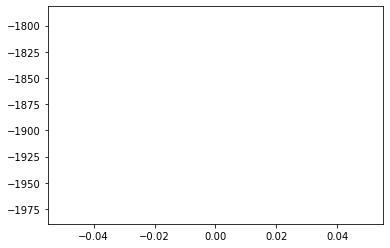

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 307 steps and return -115858.201.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -9372.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -24274.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 328 steps and return -20770.296000000002.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -30291.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -37057.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 

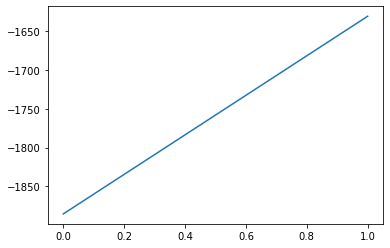

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -113529.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 53 steps and return -191736.82.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -9483.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -44091.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 116 steps and return -198841.55599999998.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 16 steps and return -38963.072.
Fighting against ['random', 'random', 'random']
This game has 373 steps and return 2695.
Fighting against [<functio

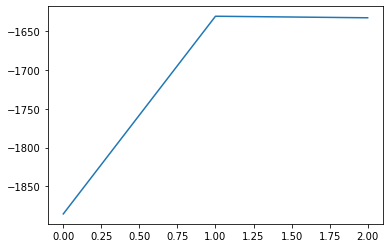

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -150933.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -114632.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 1016.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -150942.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -150730.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -16928.
Fighting against ['random', 'random', 'random']
This game has 195 steps and return -1562.7600000000002.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -143918.


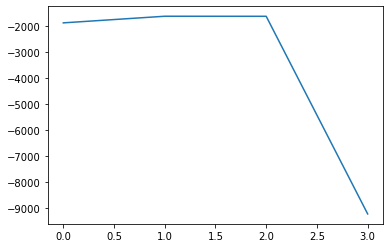

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -22237.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -27284.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -13322.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -132995.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 234 steps and return -14050.155999999999.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -128736.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This ga

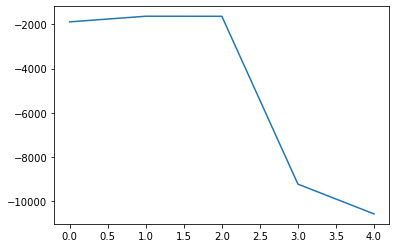

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -18493.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -53704.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -148008.
Fighting against ['random', 'random', 'random']
This game has 324 steps and return 3658.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -124417.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -12701.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 step

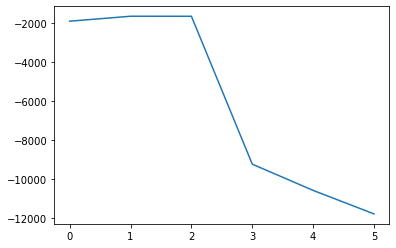

Fighting against ['random', 'random', 'random']
This game has 202 steps and return -898.874.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -17047.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -28878.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -161536.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return -436.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 273 steps and return -37270.121.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 107 steps and return -5042.651.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 s

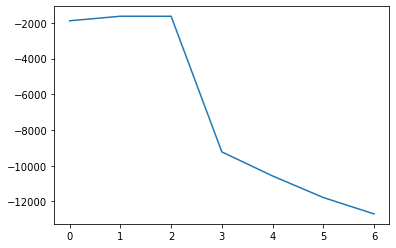

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 92 steps and return -36115.34.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 183 steps and return -203292.995.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -35703.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -16642.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -9159.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 202 steps and return -39979.944.
Fighting against [<function 

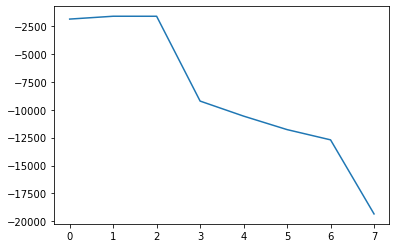

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -24405.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -52114.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -23441.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -38114.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -27408.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 3677.
Fighting against ['random', 'random', 'random']
This game has 362 steps and return 625.
Fighting against ['random', 'random', <function 

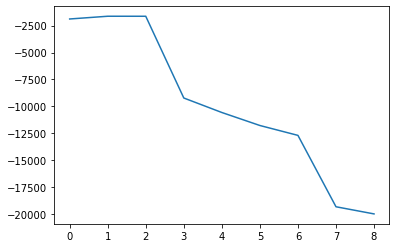

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -52156.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 3110.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 2942.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 94 steps and return -33211.708.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -9622.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 247 steps and return -159896.224.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -41004.
Fighting against [<function swarm_agent 

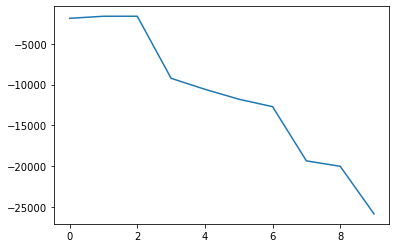

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 171 steps and return -10449.717.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -123596.
Fighting against ['random', 'random', 'random']
This game has 92 steps and return -1771.9560000000001.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -30223.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -52114.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -126340.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -16434.
Fighting against [<functi

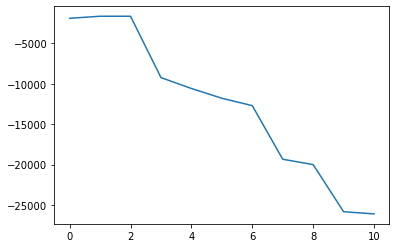

Fighting against ['random', 'random', 'random']
This game has 167 steps and return -1701.654.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -27576.
Fighting against ['random', 'random', 'random']
This game has 262 steps and return 564.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -38609.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -160633.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -155572.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -176885.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -119619.
Fighting aga

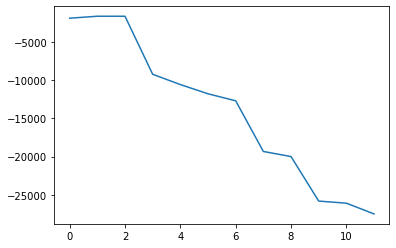

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 64 steps and return -34699.328.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -13801.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -20055.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 1410.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -43970.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -64679.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>,

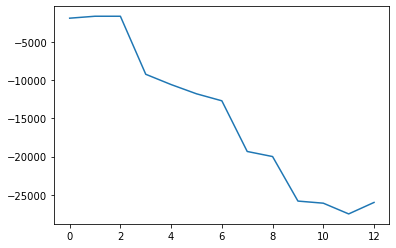

Fighting against ['random', 'random', 'random']
This game has 232 steps and return -894.6.
Fighting against ['random', 'random', 'random']
This game has 107 steps and return -1925.616.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -74731.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 239 steps and return -43340.236.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -26386.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -139422.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 148 steps and return -45024.976.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 3258.
Fighti

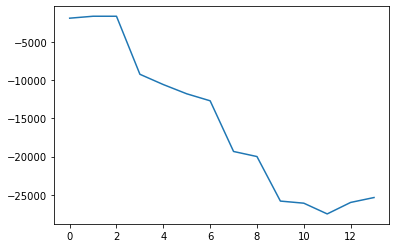

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -159784.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 60 steps and return -167302.66.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -13028.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 88 steps and return -78310.12.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -8176.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 196 steps and return -181556.916.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent 

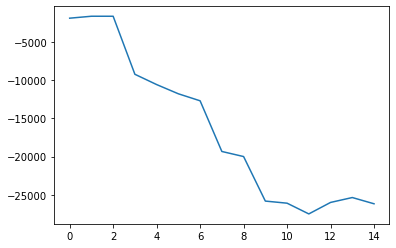

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 25 steps and return -2440.5.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -104901.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 56 steps and return -227293.096.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 110 steps and return -177046.35.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -41409.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -56208.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 2767.
Fighting against ['random', 'random', 'random']
This game has 106 steps and return -1993.748.
Fighti

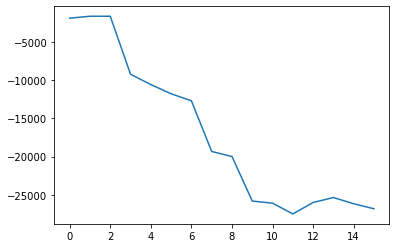

Fighting against ['random', 'random', 'random']
This game has 400 steps and return -154.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 96 steps and return -22692.432.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 315 steps and return -160377.49.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 309 steps and return -68304.593.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 143 steps and return -33403.815.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 53 steps and return -203659.593.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 143 steps and return -37548.344.
Fighting against ['random', <function swarm_agent at 0

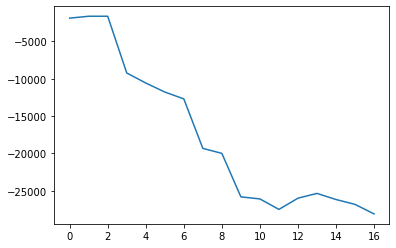

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -161924.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -28590.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -26335.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -30975.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 240 steps and return -50610.0.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -95408.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 2673.
Fighting against ['random', 'random', 'ran

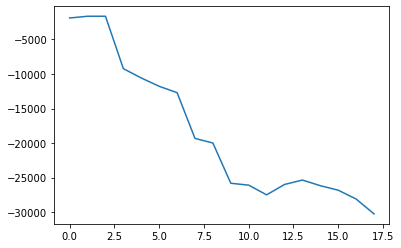

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -175900.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -134842.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -56037.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 104 steps and return -48814.664000000004.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 290 steps and return -35723.24.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -54729.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -

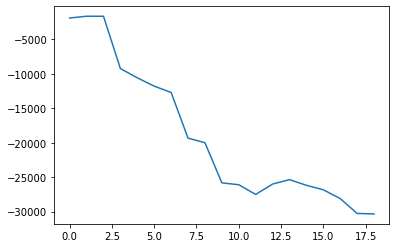

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 154 steps and return -202806.47999999998.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -17565.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -83781.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -194062.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -100387.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -147751.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -19679.
Fighting against ['random', 'random', 'random']
This game h

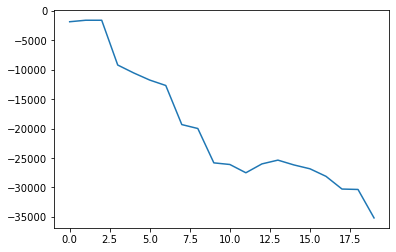

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -31628.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -161979.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 21 steps and return -45117.425.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 286 steps and return -151768.502.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -26836.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -27429.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent a

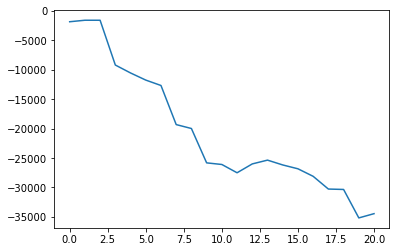

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -29644.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -116898.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -45271.
Fighting against ['random', 'random', 'random']
This game has 66 steps and return -1990.7939999999999.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 112 steps and return -37930.335999999996.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -36160.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and 

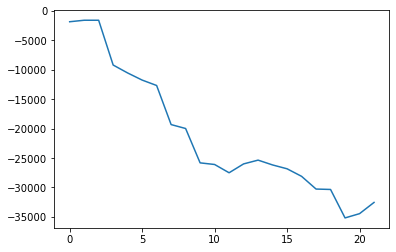

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -27568.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -47730.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -27116.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 62 steps and return -52496.263999999996.
Fighting against ['random', 'random', 'random']
This game has 194 steps and return -1092.164.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -39003.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_a

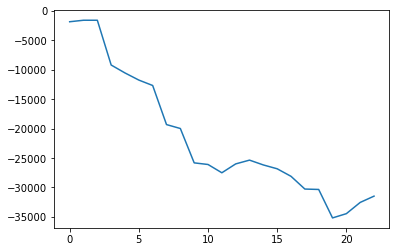

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 128 steps and return -227334.256.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -35149.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 61 steps and return -229678.485.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 52 steps and return -174224.472.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -109645.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 156 steps and return -58878.936.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -159116.
Fighting against [<function swarm_agent at 0x7fe074605c2

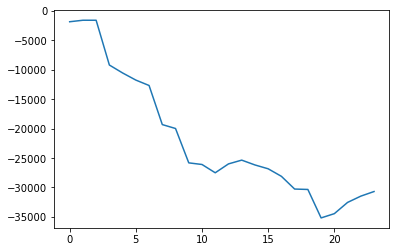

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -43395.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 155 steps and return -28201.715.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -23544.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -9688.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -16229.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -30430.
Fighting against [<function swarm_a

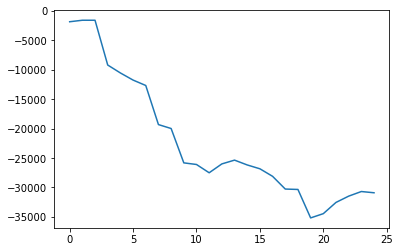

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -37071.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -15334.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -136183.
Fighting against ['random', 'random', 'random']
This game has 72 steps and return -2193.248.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -21207.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 25 steps and return -45403.125.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0

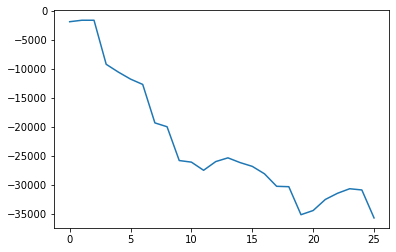

Fighting against ['random', 'random', 'random']
This game has 400 steps and return 211.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 148 steps and return -215596.02.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 110 steps and return -43028.09.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 40 steps and return -14393.0.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -82669.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 97 steps and return -43590.429000000004.
Fighting against ['random', 'random', 'random']
This game has 88 steps and return -2142.56.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game

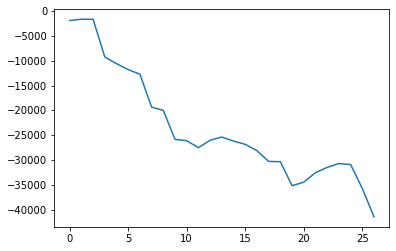

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -6798.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 94 steps and return -164793.24.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -148501.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -27103.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -102869.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -11102.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7

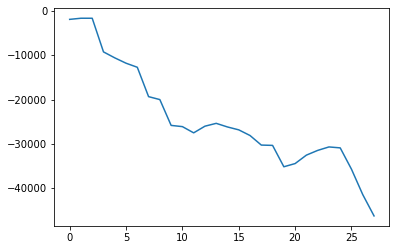

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 95 steps and return -3901.225.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -35595.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -142624.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 466.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -10055.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -110937.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -153870.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'ra

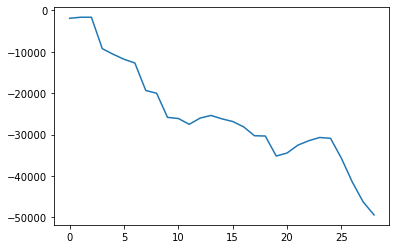

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 65 steps and return -2151.455.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -102083.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 136 steps and return -58869.632.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -110366.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 133 steps and return -32264.58.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -32910.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -159457.
Fighting against ['random', 'ra

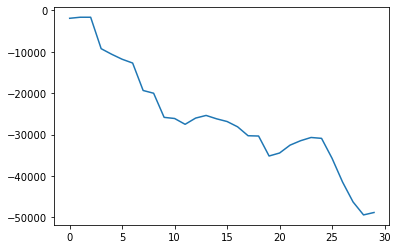

Fighting against ['random', 'random', 'random']
This game has 400 steps and return -347.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -139886.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 204 steps and return -8691.308.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -31375.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 82 steps and return -25479.09.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -60115.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -15473.
Fighting against ['random', 'random', '

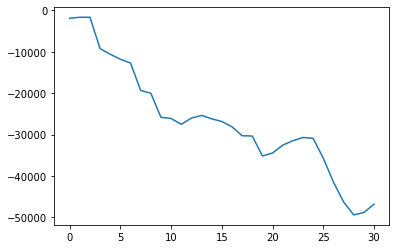

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -34722.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -52438.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 120 steps and return -162592.68.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 103 steps and return -153916.25400000002.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 2994.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 352 steps and return -10326.279999999999.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -14934.
Fighting agains

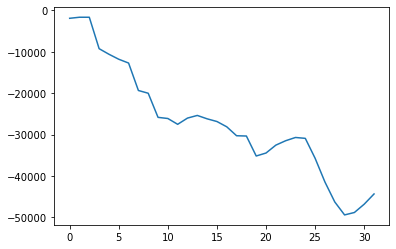

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 101 steps and return -7833.664.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -12495.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -134123.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 257 steps and return -43366.936.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -27966.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -18442.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 4284.
Fight

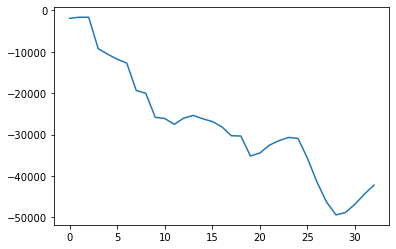

Fighting against ['random', 'random', 'random']
This game has 54 steps and return -2683.742.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -22090.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -176833.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -19061.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -34328.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -8223.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 st

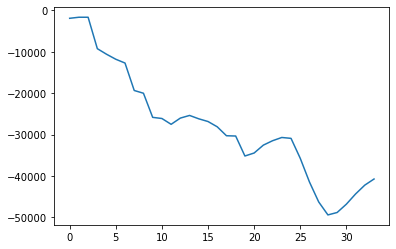

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -88084.
Fighting against ['random', 'random', 'random']
This game has 269 steps and return 3861.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -158783.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -44128.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -165586.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -18095.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 3344.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and r

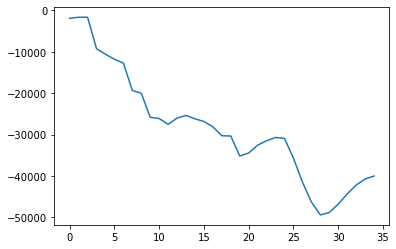

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -50692.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -14736.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 71 steps and return -55887.622.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -11280.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 153 steps and return -188570.737.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -42607.
Fighting against ['random', <f

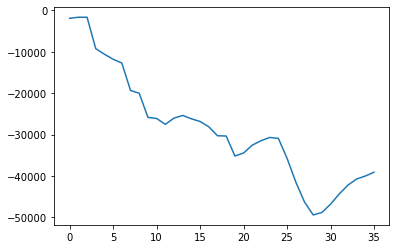

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -171959.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -43801.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -11154.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -42270.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -33925.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -12632.
Fighting against [<function swarm_age

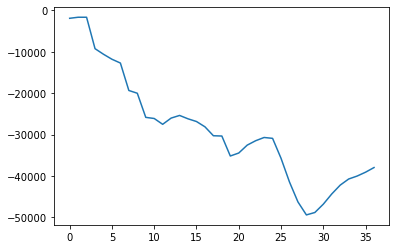

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -100008.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -25737.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -116041.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -48010.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -54550.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -45729.
Fighting against ['random', 'random', 'random']
This game has 263 steps and return 2129.
Fighting against ['random', 'random', 'rand

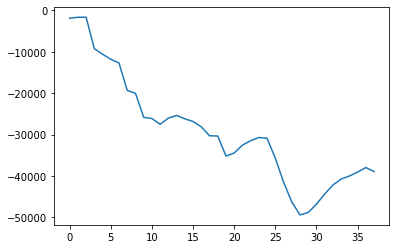

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -145539.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -123268.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 63 steps and return -124443.31.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -148168.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -81244.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -14308.
Fighting against ['random', 'random', 'random']
This game has 170 steps and return -1775.2.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>

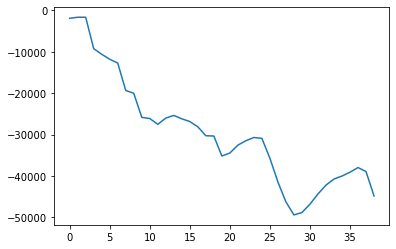

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -122509.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -23663.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -147091.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -30133.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 206 steps and return -34800.464.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -40185.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 40

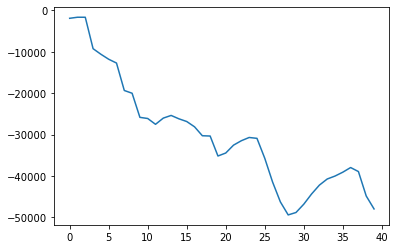

Fighting against ['random', 'random', 'random']
This game has 102 steps and return -1995.176.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -17290.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -52584.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -11267.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -164208.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 1408.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 st

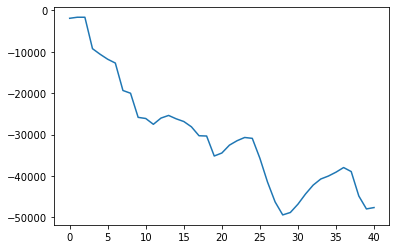

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 113 steps and return -45517.465.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 117 steps and return -6535.371999999999.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -35249.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -32482.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -30871.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -157077.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm

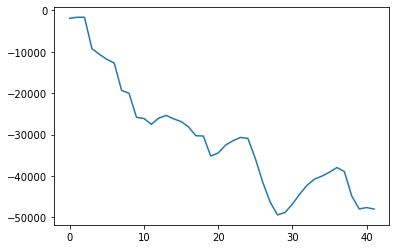

Fighting against ['random', 'random', 'random']
This game has 225 steps and return -1246.0.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -35611.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -34665.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -33634.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -26876.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -25220.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe0

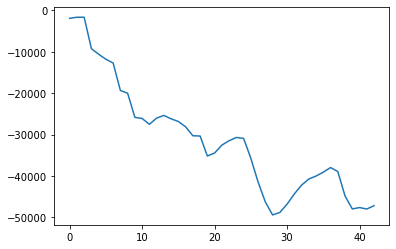

Fighting against ['random', 'random', 'random']
This game has 242 steps and return -928.2479999999999.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -29821.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -145579.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -35218.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -10024.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -36839.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game

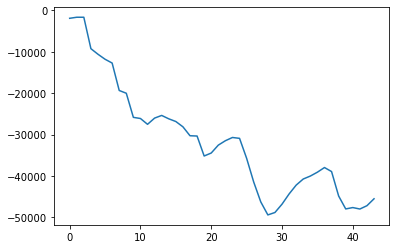

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -21512.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -24574.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 67 steps and return -144293.256.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -12991.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 5302.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -34914.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 st

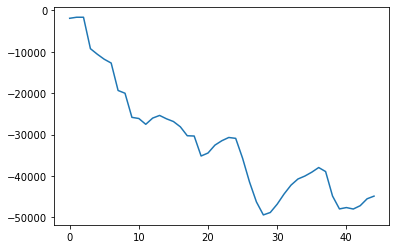

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -168576.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -20556.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -107974.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -23607.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -39152.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 112 steps and return -4800.5199999999995.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -285

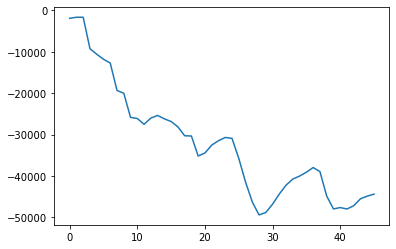

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -42567.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 92 steps and return -29155.372.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -28161.
Fighting against ['random', 'random', 'random']
This game has 255 steps and return -1212.045.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -157683.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -30068.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -137348.
Fighting against ['random', <functi

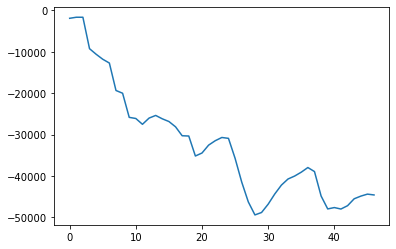

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 113 steps and return -50513.979.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -49890.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -12955.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -20863.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -33090.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 117 steps and return -213421.069.
Fighting against ['random', <function swarm_agent at 0x7fe074

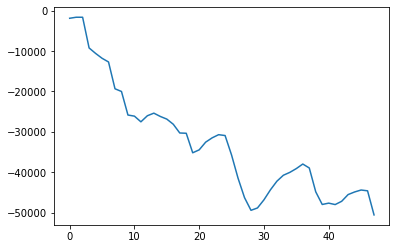

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -102273.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 125 steps and return -54822.15.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 119 steps and return -153887.04.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -87564.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -150912.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -14215.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -106425.
Fighting against ['random', 'rand

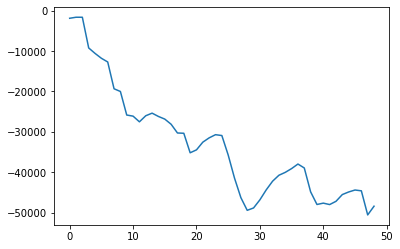

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 299 steps and return -13503.858.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -21864.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -161472.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -111210.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -28180.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -35658.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -47263.
Fight

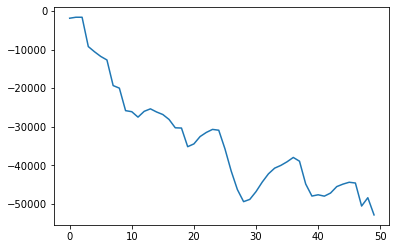

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 157 steps and return -78004.935.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 3710.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -114806.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -20342.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -13500.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -130523.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 

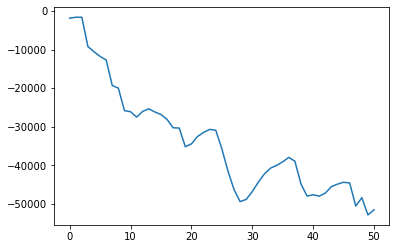

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 309 steps and return -29592.597999999998.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -19089.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -30548.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 129 steps and return -123052.173.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -16243.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -144740.
Fighting against ['random', 'random', 'random']
This game has 66 steps and return -

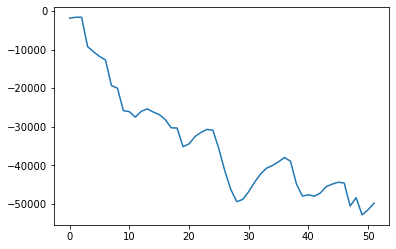

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 324 steps and return -150506.164.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -154556.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -138172.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -120705.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -35475.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 120 steps and return -153221.6.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 58 steps and return -60873.05.
Fighting against ['random', <function swarm_agent at 0x7fe0746

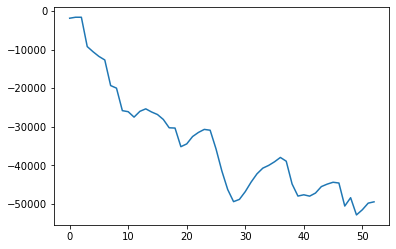

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 149 steps and return -30596.494.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 125 steps and return -109306.925.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -97401.
Fighting against ['random', 'random', 'random']
This game has 369 steps and return -104.873.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -37543.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -163148.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -137531.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe0746

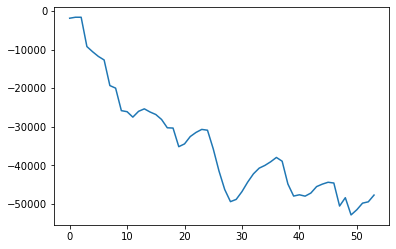

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -13674.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -24800.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 170 steps and return -47424.96.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 1630.
Fighting against ['random', 'random', 'random']
This game has 257 steps and return -1200.504.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -47274.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -151306.
Fighting against ['random', 'random', 

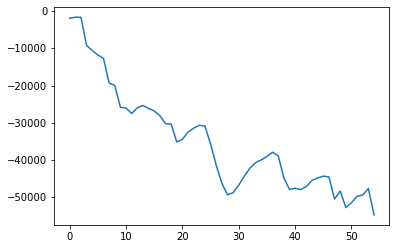

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -118285.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -24996.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -119289.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -24616.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -110129.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -43770.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 s

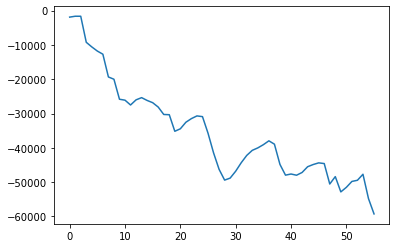

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -218736.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -83820.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 120 steps and return -200149.68.
Fighting against ['random', 'random', 'random']
This game has 257 steps and return 1685.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -33963.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -38558.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -35242.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <f

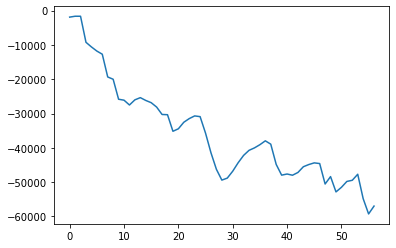

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -30709.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -147537.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 166 steps and return -20017.468.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -150571.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -33480.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -32536.
Fighting against ['random', 'random', 'random']
This game has 85 steps and return -1776.78.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <functio

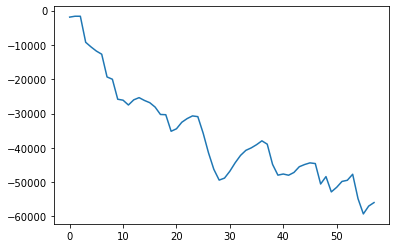

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -83860.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 208 steps and return -125183.872.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -9902.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 182 steps and return -21790.582.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 55 steps and return -32308.1.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 106 steps and return -21642.352.
Fighting against [<function swarm_agent at 0x7fe074605c20

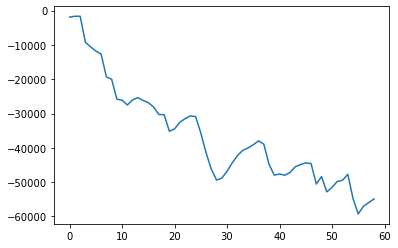

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -137799.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 120 steps and return -43593.96.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -14660.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return -9.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -144470.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -117493.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 137 steps and return -33655.318.
Fighting against ['random', <function

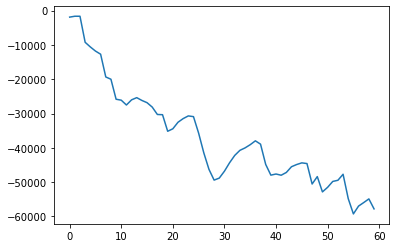

Fighting against ['random', 'random', 'random']
This game has 400 steps and return 1740.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -91549.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 94 steps and return -41425.088.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -30155.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 264 steps and return -14566.552.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -67455.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -94926.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 

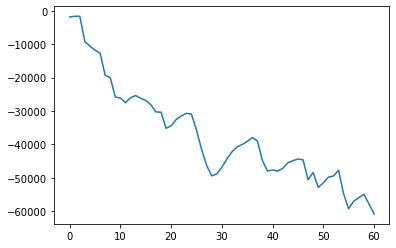

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 159 steps and return -30956.29.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 198 steps and return -14638.856.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 203 steps and return -189944.365.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -13982.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 364 steps and return -44731.728.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -102723.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 238 steps and return -3

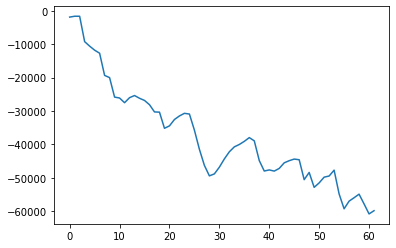

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -129608.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 325 steps and return -138206.425.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 204 steps and return -41830.124.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -28682.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 100 steps and return -162883.2.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 165 steps and return -208675.025.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 3084.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game h

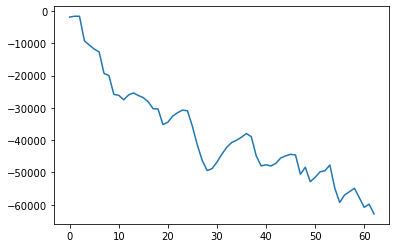

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -146732.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -15234.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -194351.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -32448.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -49255.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -96316.
Fighting against ['random', 'random', 'random']
This game has 208 steps and return -1282.784.
Fighting against ['random', <function 

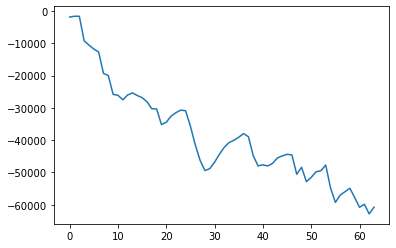

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -44440.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -8998.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 35 steps and return -184414.475.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -37603.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -147354.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -26992.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 

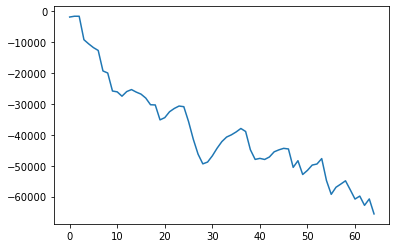

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -26832.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -30398.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 83 steps and return -27525.133.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -35526.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 136 steps and return -7465.136.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 2285.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -34850.
Fightin

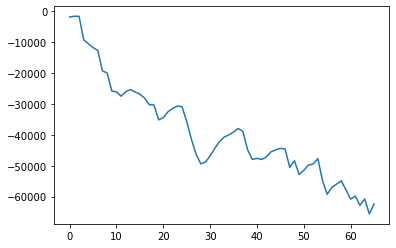

Fighting against ['random', 'random', 'random']
This game has 73 steps and return -1971.481.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 114 steps and return -9616.082.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 217 steps and return -206333.77.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -149754.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -26456.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -31797.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -14652.
Fighting against ['random', <func

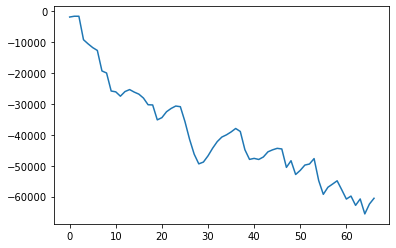

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -167857.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -131767.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 143 steps and return -7237.827.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -28414.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -19927.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -159329.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -130991.
Fighting against [<function swarm_ag

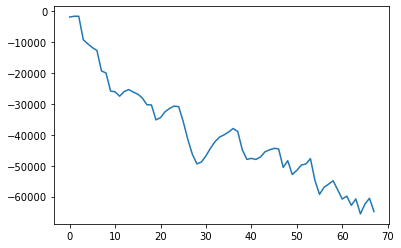

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -38291.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 146 steps and return -200410.624.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -33258.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 220.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -27387.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -23670.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 926.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c2

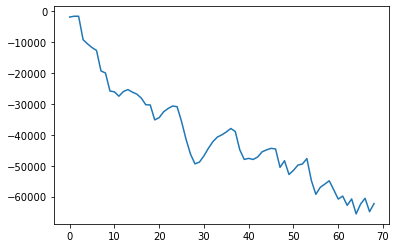

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -40664.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -11623.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -30453.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -142117.
Fighting against ['random', 'random', 'random']
This game has 113 steps and return -1615.644.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 2662.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -31385.
Fighting against ['random', 'random', 'ra

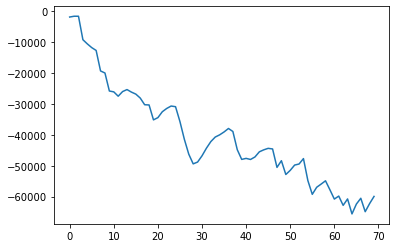

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 174 steps and return -159453.476.
Fighting against ['random', 'random', 'random']
This game has 155 steps and return -1495.485.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -162044.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -120096.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 177 steps and return -34417.886.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -31579.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -147176.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game ha

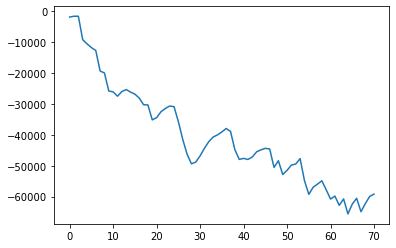

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -159952.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -105688.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 213 steps and return -33768.003.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 55 steps and return -225769.95.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -120859.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -23234.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -126150.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <fun

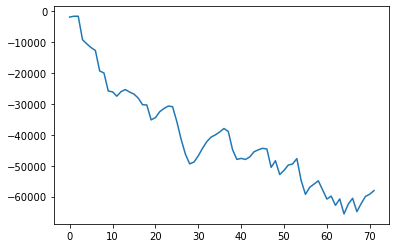

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -152263.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 276 steps and return -22597.292.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -14227.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -28798.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -138518.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -20232.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -114907.
Figh

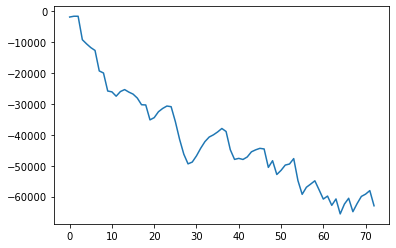

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -24544.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -12205.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -162306.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -131862.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -14811.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -156406.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20

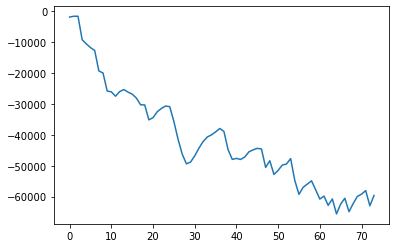

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 155 steps and return -14970.315.
Fighting against ['random', 'random', 'random']
This game has 106 steps and return -2241.384.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -41677.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -20825.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -9474.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -49865.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0

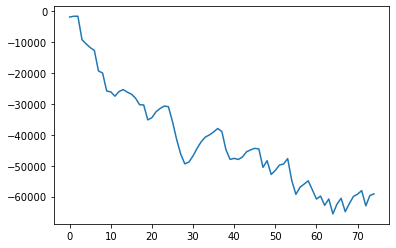

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -157796.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -45263.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 128 steps and return -212829.848.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -130210.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -126099.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -38517.
Fighting against ['random', 'random', 'random']
This game has 148 steps and return -1478.0720000000001.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This g

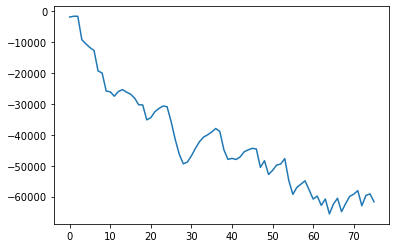

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -139686.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -156087.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -153037.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -53652.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -112172.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -30256.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -35584.
Fighting against [<function swarm_agent

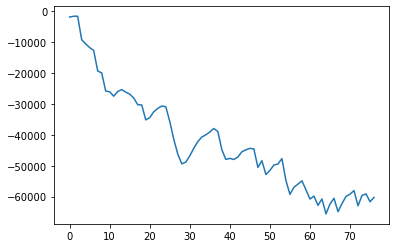

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -29125.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -39559.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 305 steps and return -173233.265.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -29421.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -19319.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 76 steps and return -112887.756.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has

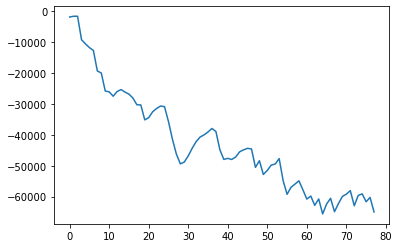

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -11132.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -174891.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -17582.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -36690.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -12473.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -154664.
Fighting against [<function swarm_ag

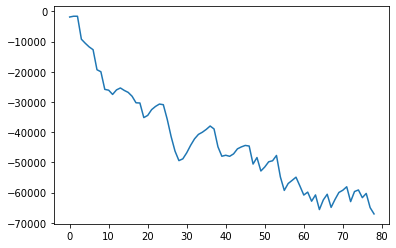

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -140131.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 254 steps and return -13042.148000000001.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -147289.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -8407.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -153573.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -161082.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -33227.
Fighting against [<function

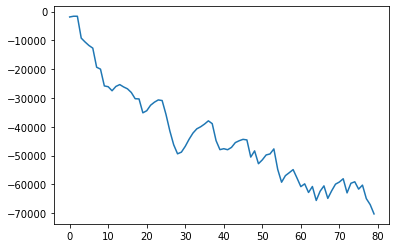

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 22 steps and return -26208.976000000002.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -132121.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -142638.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -181792.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -166972.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -166561.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 107 steps and return -34453.388.
Fighting against [<fun

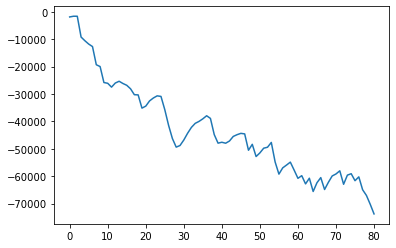

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -27167.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -87187.
Fighting against ['random', 'random', 'random']
This game has 52 steps and return -2498.7960000000003.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -132073.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 185 steps and return -38911.85.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 200 steps and return -164572.4.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 127 steps and return -193865.9.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 18

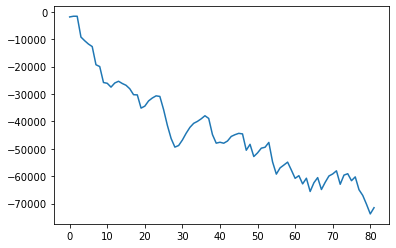

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -28794.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -26844.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -29607.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -89367.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -25444.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -101151.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -114611.
Fighting 

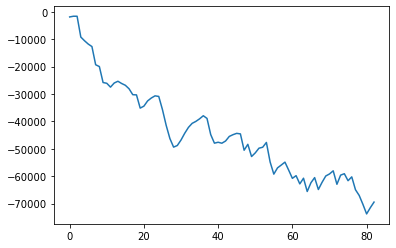

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -47229.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -23670.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -24931.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -81928.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -175933.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -9398.
Fighting against ['random', 'random', 'random']
This game has 400 step

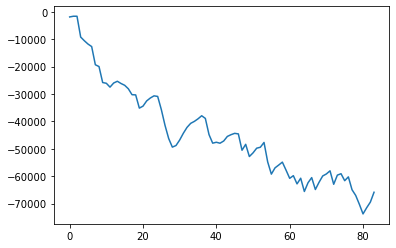

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 186 steps and return -65780.76.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -160603.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -31171.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 51 steps and return -33252.248999999996.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 173 steps and return -180848.12.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 5000.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -31458.
Fighting against ['random', <function swarm_agent at 0x7f

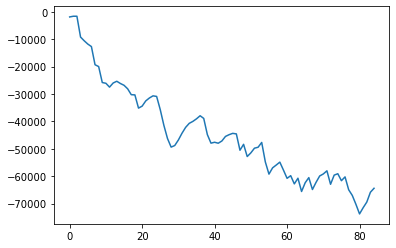

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -5419.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -23236.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -29495.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -33379.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -15529.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -189636.
Fighting against [<function swarm_agen

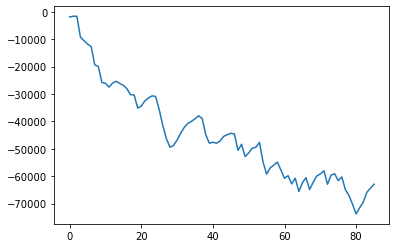

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -147089.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -145046.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -41865.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -159846.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -20167.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -20487.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 s

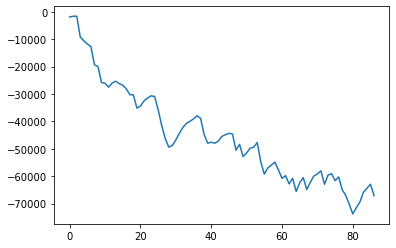

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -52185.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -154850.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -171418.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -56744.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -37467.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -43769.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 st

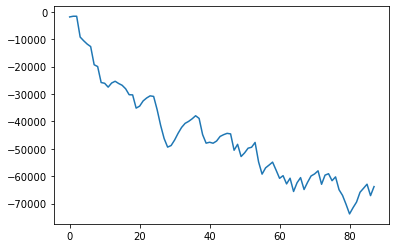

Fighting against ['random', 'random', 'random']
This game has 400 steps and return 2667.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -135124.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -132122.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -121469.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -54614.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -28218.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -123028.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps a

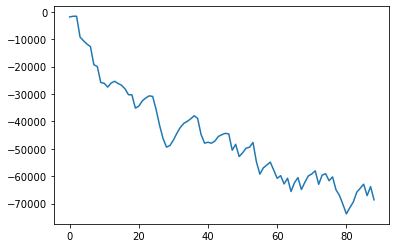

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 131 steps and return -34664.553.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -153765.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -144979.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -134584.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -23748.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 83 steps and return -2713.35.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 235 steps and return -88859.79.
Fighting against ['random', 'random', <function swarm_agent at 0

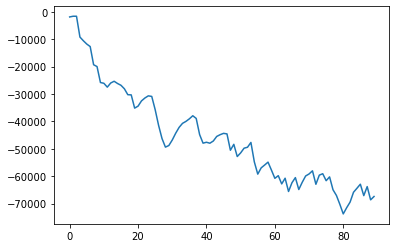

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -38253.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -140323.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -62344.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 238 steps and return -155354.78399999999.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -48692.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -8340.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game

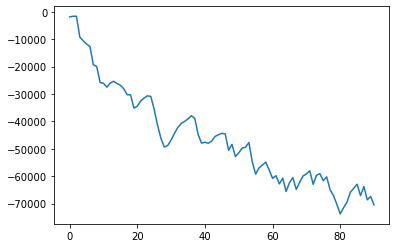

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -94805.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -25970.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -132589.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 85 steps and return -8084.115.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -74756.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -34115.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -162686.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', '

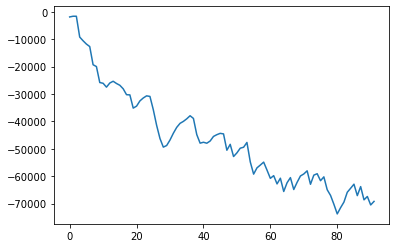

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -19560.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -15067.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -21696.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -141164.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -130981.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -11789.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe

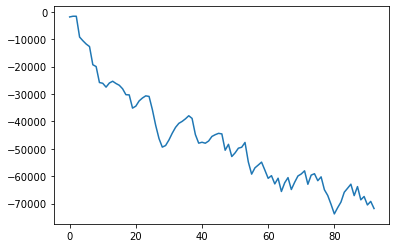

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -32941.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -140125.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -32800.
Fighting against ['random', 'random', 'random']
This game has 125 steps and return -1795.775.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 86 steps and return -34224.65.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -71986.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -26315.
Fight

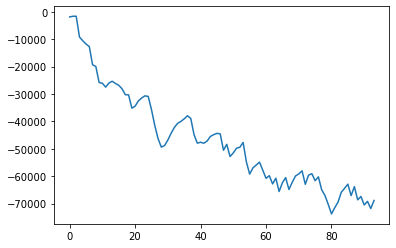

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -28937.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 130 steps and return -25486.37.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -135890.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -103325.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -189048.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -43116.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -37841.
Fight

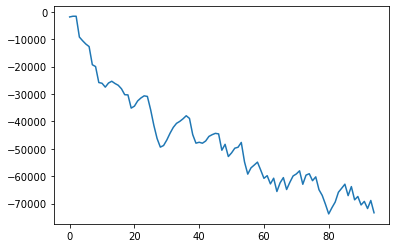

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -167520.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -134592.
Fighting against ['random', 'random', 'random']
This game has 189 steps and return -1327.36.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 186 steps and return -10677.328.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -16035.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -40978.
Fighting against ['random', 'random', 'random']
This game has 136 steps and return -2093.704.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -171681.
Figh

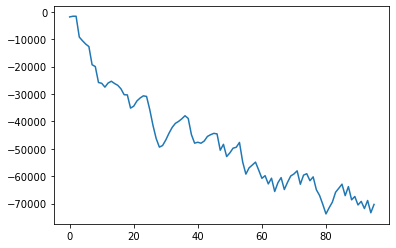

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -181833.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -163421.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -178964.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -32289.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -29708.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -30375.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -106346.
Fighting against [<function swarm_agent

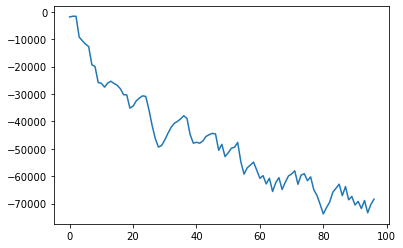

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -32359.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -26222.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 58 steps and return -13739.038.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 69 steps and return -60643.19.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -33623.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -33704.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x

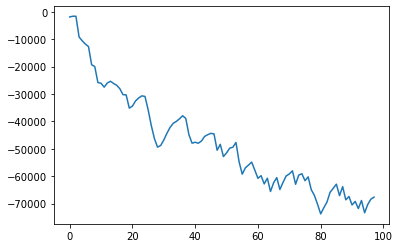

Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -44979.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -145662.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -156182.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -32698.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -26638.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -20317.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe

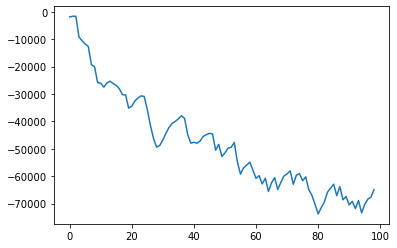

Fighting against ['random', 'random', 'random']
This game has 159 steps and return -1424.9470000000001.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 178 steps and return -145679.806.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -34856.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -159547.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -173951.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -131793.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -42768.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This g

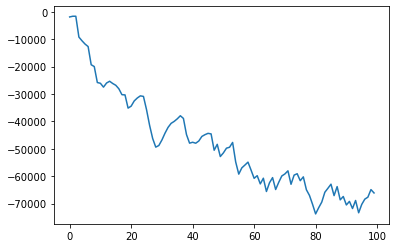

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 93 steps and return -42567.627.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 100 steps and return -234998.7.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -137923.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -142153.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -146629.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -113908.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -15900.
Fighting against ['random', <func

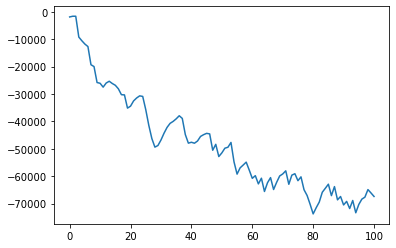

Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -40859.
Fighting against ['random', 'random', 'random']
This game has 357 steps and return 3379.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -15354.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 2872.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -28190.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -124855.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 82 steps and return -178057.894.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <fun

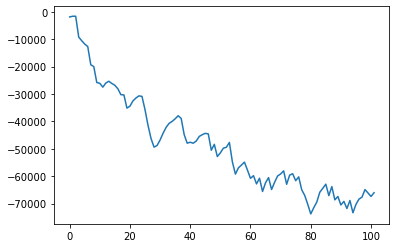

Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -178835.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -44016.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -13272.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -57116.
Fighting against ['random', 'random', 'random']
This game has 400 steps and return 1606.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -26765.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 69 steps 

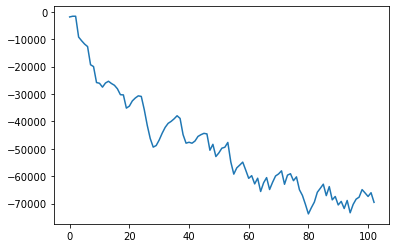

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -150384.
Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 400 steps and return -161500.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -42924.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, 'random']
This game has 400 steps and return -47199.
Fighting against ['random', 'random', <function swarm_agent at 0x7fe074605c20>]
This game has 97 steps and return -200274.886.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -13917.
Fighting against [<function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0

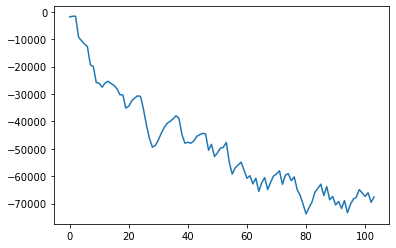

Fighting against [<function swarm_agent at 0x7fe074605c20>, 'random', 'random']
This game has 86 steps and return -4414.648.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -53653.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]
This game has 400 steps and return -26698.
Fighting against ['random', <function swarm_agent at 0x7fe074605c20>, <function swarm_agent at 0x7fe074605c20>]


In [ ]:
## The structure of this was originally taken from https://keras.io/examples/rl/actor_critic_cartpole, authored by Apoorv Nandan, 2020/05/13

yard_optimizer = yard_model.optimizer
ship_optimizer = ship_model.optimizer
q_optimizer = q_model.optimizer
returns = []
running_reward = 0
episode_count = 0

episode_steps = 400

epsilon = 0.01

player = 0

fig = plt.figure()

episodes_to_run = 10

buffer = PriorityReplayBuffer(20000)

while True:  # Run until solved
    
    for i in range(episodes_to_run):
        
        env = make("halite", configuration={"episodeSteps": episode_steps}, debug=True)
        conf = env.configuration
        state = env.reset(4)[0]
        nn_borg = NeuralBorg(Board(state.observation, conf))

        enemy_array = choices([swarm_agent, "random"], k=3)
        print(f"Fighting against {enemy_array}")

        # CREATE A NEW EPISODE
        actual_steps = env.run([NeuroAgent, *enemy_array])

        steps_no = len(actual_steps)
        max_steps = env.configuration['episodeSteps']

        # find the final return, expressed as my score minus the max of the enemies'
        # rewards here are based on the last step (final) score
        # base case: get the return from the last step
        final_scores = [actual_steps[-1][i]['reward'] for i in range(4)]
        best_opponent_score = max([final_scores[i] for i in {0,1,2,3}-{player}])
        undiscounted_return = final_scores[player] - best_opponent_score

        # temporal discounting
        gamma = 0.99

        # arrays for reporting purposes
        step_yard_loss = []
        step_ship_loss = []
        step_q_loss = []
        step_critic_loss = []

        cumul_reward = undiscounted_return

        # picking the last step
        cur_yard_inputs, cur_ship_inputs, q_inputs = borgPreprocessor.processStep(steps_no, actual_steps[steps_no-1], player, cumul_reward, undiscounted_return)

        # sometimes the actual number of significant steps is less than the formal one (usually 400),
        # or even than the ones that have actually been recorded (e.g. 340 steps recorded but only 100 significant).
        # A step is significant if the relevant player has at least a ship or a yard.
        # We need to count the null steps if we want to have an accurate estimate of the returns.
        while (cur_yard_inputs[4] is None or len(cur_yard_inputs[4]) == 0) and (cur_ship_inputs[4] is None or len(cur_ship_inputs[4]) == 0):
            # if the last step we processed is actually non significant, control the previous one
            steps_no -= 1
            cur_yard_inputs, cur_ship_inputs, q_inputs = borgPreprocessor.processStep(steps_no, actual_steps[steps_no - 1], player, cumul_reward, undiscounted_return)
        

        if steps_no < max_steps and not borgPreprocessor.is_winner(actual_steps[steps_no-1], player, steps_no, max_steps):
            # if one or more steps were null, we need to revise the estimation of the undiscounted return.
            # We apply a penalty that increases (slowly) exponentially,
            # in order to reflect the increasing gains of the later steps
            # (enemies usually have more ships later in the game,
            # therefore the opportunity cost should be higher)
            
            # retrieve the reward for the last step
            if cur_ship_inputs[3] is not None and len(cur_ship_inputs[3]) > 0:
                last_reward = cur_ship_inputs[3][0]
            elif cur_yard_inputs[3] is not None and len(cur_yard_inputs[3]) > 0:
                last_reward = cur_yard_inputs[3][0]  

            null_steps = max_steps - steps_no
            penalty = min(np.abs(last_reward), 500) * null_steps
            undiscounted_return -= penalty
            cumul_reward -= penalty
            cur_yard_inputs, cur_ship_inputs, q_inputs = borgPreprocessor.processStep(steps_no, actual_steps[steps_no - 1], player, cumul_reward, undiscounted_return)
        
        # finally, retrieve all the previous steps and insert them in the buffer
        
        for i in reversed(range(steps_no - 1)):
            
            next_yard_inputs, next_ship_inputs, next_q_inputs = cur_yard_inputs, cur_ship_inputs, q_inputs
            cur_yard_inputs, cur_ship_inputs, q_inputs = borgPreprocessor.processStep(steps_no, actual_steps[i], player, cumul_reward, undiscounted_return)
            buffer.addObs([cur_yard_inputs, cur_ship_inputs, q_inputs, next_yard_inputs, next_ship_inputs, next_q_inputs])
            #traverse(buffer.tree.root)
            
        print(f"This game has {steps_no} steps and return {undiscounted_return}.")
    
    #### LEARNING CYCLE ####
    sample_size = 1000
    ids, sample = buffer.sampleObs(sample_size)
    
    # for reporting
    critic_loss, yard_loss, ship_loss, q_loss = ([], [], [], [])
    
    for i in range(len(sample)):
        step_critic_loss, step_yard_loss, step_ship_loss, step_q_loss =\
            learn_from_sample(cur_yard_inputs, cur_ship_inputs, q_inputs, next_yard_inputs, next_ship_inputs, next_q_inputs)
        critic_loss.append(step_critic_loss)
        yard_loss.append(step_yard_loss)
        ship_loss.append(step_ship_loss)
        q_loss.append(step_q_loss)
        
    # DOUBLE Q LEARNING UPDATE:
    # Slowly update the target network
    q_prime_model = polyak_update(q_model, q_prime_model, 0.01)
    
    # UPDATE THE PRIORITIES
    buffer.takeUpdate(ids, np.sqrt(q_loss)[:,0])
    
    # REPORTING LOSSES AND RETURNS
    if not np.isnan(np.mean(yard_loss)):
        print(f"yard model loss: {np.mean(yard_loss)+np.mean(critic_loss)} from yard_actor_loss {np.mean(yard_loss)} and critic_loss {np.mean(critic_loss)}")
    if not np.isnan(np.mean(ship_loss)):
        print(f"ship model loss: {np.mean(ship_loss)+np.mean(critic_loss)} from ship_actor_loss {np.mean(ship_loss)} and critic_loss {np.mean(critic_loss)}")
    print(f"q-value loss: {np.mean(q_loss)}")
    running_reward = 0.05 * undiscounted_return + 0.95 * running_reward
    returns.append(running_reward)
    episode_count += 1
    print(f"running reward: {running_reward:.2f} after {episode_count*1000} steps examined.")
    
    # SAVE THE MODELS AND SHOW THE RETURNS TREND PERIODICALLY
    if episode_count % 1 == 0:
        #env.render(mode="ipython", width=600, height=450)
        ship_model.save("../output/shipNN_trained_experience.h5")
        yard_model.save("../output/yardNN_trained_experience.h5")
        q_model.save("../output/qNN_trained_experience.h5")
        plt.plot(returns)
        plt.show()

    # EXIT THE LOOP IF THE MODEL IS SUFFICIENTLY STRONG
    if running_reward > 10000.0:  # Condition to consider the task solved
        print(f"Solved at episode {episode_count}!")
        break

In [ ]:
for i in range(100):
    random_val = randint(0, buffer.tree.root.val)
    print(random_val)
    random_leaf = buffer.tree.retrieve(random_val)
    print(random_leaf.index)

In [38]:
indexes = set()
one_child = 0
def traverse(node):
    global one_child
    if node.is_leaf:
        return
    else:
        if node.left_child is not None and node.right_child is None:
            if node.val != node.left_child.val:
                print(f"found node with an inconsistent sum: the parent has sum {node.val} but the left child has value {node.left_child.val}")
            traverse(node.left_child)
        elif node.right_child is not None and node.left_child is None:
            if node.val != node.right_child.val:
                print(f"found node with an inconsistent sum: the parent has sum {node.val} but the left child has value {node.right_child.val}")
            traverse(node.right_child)
        elif node.right_child is not None and node.left_child is not None:
            if node.val != node.right_child.val + node.left_child.val:
                print(f"found node with an inconsistent sum: the parent has sum {node.val} but the children have value {node.left_child.val} and {node.right_child.val}")
            traverse(node.right_child)
            traverse(node.left_child)

traverse(buffer.tree.root)

found node with an inconsistent sum: the parent has sum 4000 but the children have value 1000 and 1000


In [39]:
buffer.tree.root.val, buffer.tree.root.right_child.index, buffer.tree.root.right_child.is_leaf

(4000, 1, True)

In [40]:
buffer.tree.root.left_child.val, buffer.tree.root.right_child.val

(1000, 1000)

In [37]:
for i in range(len(buffer.buffer)):
    p = buffer.buffer[i]
    d = 0
    while p.parent is not None:
        p = p.parent
        d += 1
        if d > 2*len(buffer.buffer):
            print("probabile loop infinito")
            break
    print(d, buffer.buffer[i], buffer.buffer[i].parent)

1 <__main__.STNode object at 0x7fdfc8268b90> <__main__.STNode object at 0x7fdfc861e3d0>
2 <__main__.STNode object at 0x7fdfc8268790> <__main__.STNode object at 0x7fdfa284cad0>
2 <__main__.STNode object at 0x7fdfc8268690> <__main__.STNode object at 0x7fdfa284cad0>
0 <__main__.STNode object at 0x7fdfc82f5890> None


In [ ]:
buffer.tree.root.left_child.left_child.left_child.left_child.left_child.left_child.left_child.left_child.left_child.is_leaf

In [ ]:
ship_model.save("../output/shipNN_trained_experience.h5")
yard_model.save("../output/yardNN_trained_experience.h5")
q_model.save("../output/qNN_trained_experience.h5")

In [ ]:
env = make("halite", debug=True)
state = env.reset(4)[0]
obs = env.state[0]['observation']
conf = env.configuration
nn_borg = NeuralBorg(Board(obs, conf))
steps = env.run([NeuroAgent, "random", "random", "random"])
print(f"This game has {len(steps)} steps recorded.")
env.render(mode="ipython", width=800, height=600)

In [ ]:
%notebook -e main_file.ipynb